In [124]:
#!/usr/bin/env python
# coding: utf-8
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import time
import datetime as dt
from datetime import datetime
from datetime import timedelta
import shlex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num as d2
import fileinput
import icecream as ic
from matplotlib.ticker import PercentFormatter
import arrow
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

path = r'C:\Users\tsadmin\PycharmProjects\Codewars\Chess_scraping\\'
root = 'ubad00d_2019-2022'
filename = path + root + '.txt'  # This is the path where the final CSV gets created
person_of_interest = 'ubad00d'
UTC_DATE_KEY = '[UTCDate "'
UTC_TIME_KEY = '[UTCTime "'
termination = '[Termination'

In [3]:
def main():
    Total_games = 0
    with open(path + root + '.txt', 'r') as infile:

        lines = infile.readlines()

        utc_date = None
        utc_time = None
        utc_endtime = ''

        empty_data = {'time': [],
                      'end_time': [],
                      'result': [],
                      'colour': [],
                      'reason': [],
                      'white_elo': [],
                      'black_elo': [],
                      'opening': [],
                      'EC0': []
                      }

        final_data = {'time': [],
                      'end_time': [],
                      'result': [],
                      'colour': [],
                      'reason': [],
                      'white_elo': [],
                      'black_elo': [],
                      'opening': [],
                      'EC0': []
                      }

        temp_data = {'time': [],
                     'end_time': [],
                     'result': [],
                     'colour': [],
                     'reason': [],
                     'white_elo': [],
                     'black_elo': [],
                     'opening': [],
                     'EC0': []
                     }
        winsby = {'checkmate': 0, 'resignation': 0, 'time': 0, 'abandoned': 0}
        drawsby = {'repetition': 0, 'stalemate': 0, 'agreement': 0, 'insufficient material': 0,
                   'timeout vs insufficient material': 0, '50-move rule': 0}
        lossby = {'checkmate': 0, 'resignation': 0, 'time': 0, 'abandoned': 0}
        win_total = 0
        loss_total = 0
        draw_total = 0

        # Now we're going through all the games line by line (of the PGN format)

        for line in lines:
            fmt = '%Y.%m.%d %H:%M:%S'
            if f'White "{person_of_interest}"' in line:
                temp_data['colour'].append('White')
            if f'Black "{person_of_interest}"' in line:
                temp_data['colour'].append('Black')
                tester = True 
            if line.startswith('[WhiteElo "'):
                WHITE_ELO = line[len('[WhiteElo "'):-3]
                temp_data['white_elo'].append(WHITE_ELO)
            if line.startswith('[BlackElo "'):
                BLACK_ELO = line[len('[BlackElo "'):-3]
                temp_data['black_elo'].append(BLACK_ELO)
            if line.startswith(UTC_DATE_KEY):
                utc_date = line[len(UTC_DATE_KEY):-3]
            if line.startswith(UTC_TIME_KEY):
                utc_time = line[len(UTC_TIME_KEY):-3]
                timestamp = datetime.strptime(utc_date + ' ' + utc_time, fmt)
                temp_data['time'].append(timestamp)
            if line.startswith('[EndTime "'):
                utc_endtime = line[len('[EndTime "'):-3]
                end_timestamp = datetime.strptime(utc_date + ' ' + utc_endtime, fmt)
                temp_data['end_time'].append(end_timestamp)
            if line.startswith('[ECO "'):
                ECO = line[len('[ECO "'):-3]
                temp_data['EC0'].append(ECO)
            if line.startswith('[ECOUrl'):
                opening = line[len('[ECOUrl "https://www.chess.com/openings/'):-3]
                temp_data['opening'].append(opening)
                
    
            if ('time_control' in line) and ('time_control=\'600\'' not in line):
                # reinitialise temp_data
                temp_data = {'time': [],
                        'end_time': [],
                        'result': [],
                        'colour': [],
                        'reason': [],
                        'white_elo': [],
                        'black_elo': [],
                        'opening': [],
                        'EC0': []
                            }
                continue 
            if ('time_control=\'600\'' in line):
                # save data (temp) to final data, then reinitiliase data (temp)
                if temp_data != empty_data:
                    if (temp_data['opening'] and temp_data['EC0']) == []:
                        temp_data['opening'].append('None')
                        temp_data['EC0'].append('None')
                    for i in temp_data:
                        final_data[i] = final_data[i] + temp_data[i]

                    temp_data = {'time': [],
                    'end_time': [],
                    'result': [],
                    'colour': [],
                    'reason': [],
                    'white_elo': [],
                    'black_elo': [],
                    'opening': [],
                    'EC0': []
                        }
                        
        for line in lines:
            if termination in line:
                if 'Game drawn by' in line:
                    reason_parts = shlex.split(line.strip('[]\n'))[1].split()
                    draw_reason = ' '.join(reason_parts[3:])
                    draw_total += 1
                    temp_data['reason'].append(draw_reason)
                    temp_data['result'].append('draw')
                elif person_of_interest in line:
                    if 'won' in line:
                        reason_parts = shlex.split(line.strip('[]\n'))[1].split()
                        reason = reason_parts[len(reason_parts) - 1]
                        temp_data['reason'].append(reason)
                        temp_data['result'].append('win')
                        win_total += 1
                elif person_of_interest not in line and 'won' in line:
                    reason_parts = shlex.split(line.strip('[]\n'))[1].split()
                    loss_reason = reason_parts[len(reason_parts) - 1]
                    temp_data['reason'].append(loss_reason)
                    temp_data['result'].append('loss')
                    loss_total += 1
            if ('time_control' in line) and ('time_control=\'600\'' not in line):
            # delete temp data
                temp_data = {'time': [],
                            'end_time': [],
                            'result': [],
                            'colour': [],
                            'reason': [],
                            'white_elo': [],
                            'black_elo': [],
                            'opening': [],
                            'EC0': []
                            }
                continue 
            if 'time_control=\'600\'' in line:
                # save temp_data to final data, then reinitiliase temp_data
                if temp_data != empty_data:
                    for i in temp_data:
                        final_data[i] = [*final_data[i], *temp_data[i]]

                    temp_data = {'time': [],
                    'end_time': [],
                    'result': [],
                    'colour': [],
                    'reason': [],
                    'white_elo': [],
                    'black_elo': [],
                    'opening': [],
                    'EC0': []
                                }

        chess_data = pd.DataFrame(final_data)

        return chess_data
#         return final_data


In [4]:
chess_data = main()

In [5]:
chess_data

,time,end_time,result,colour,reason,white_elo,black_elo,opening,EC0
0,2019-11-17 22:04:41,2019-11-17 22:08:19,win,Black,abandoned,893,1307,Grob-Opening-Alessi-Gambit,A00
1,2019-11-17 22:12:00,2019-11-17 22:29:06,win,White,time,1353,847,English-Opening-Symmetrical-Variation,A30
2,2019-11-24 03:20:20,2019-11-24 03:29:54,loss,White,checkmate,1220,1357,Queens-Pawn-Opening-Levitsky-Attack-2...h6,D00
3,2019-11-24 13:48:58,2019-11-24 14:05:39,loss,Black,time,1308,1131,Caro-Kann-Defense-2.Nf3,B10
4,2019-11-24 19:10:15,2019-11-24 19:20:13,loss,White,checkmate,1046,1122,Nimzowitsch-Defense-Declined,B00
...,...,...,...,...,...,...,...,...,...
2782,2021-09-19 09:30:17,2021-09-19 09:47:36,loss,White,resignation,1598,1674,Queens-Gambit-Accepted-Central-Variation-Greco...,D20
2783,2021-09-19 09:51:43,2021-09-19 10:08:49,win,Black,resignation,1551,1605,Bishops-Opening-Boi-Variation,C20
2784,2021-09-21 09:37:22,2021-09-21 09:46:38,loss,Black,resignation,1591,1596,Queens-Pawn-Opening-Accelerated-London-System,D00
2785,2021-09-21 09:46:50,2021-09-21 10:04:50,win,Black,resignation,1628,1605,Slav-Defense-3.Nc3,D10


In [6]:
#converting elo values from str to int.
chess_data[["white_elo", "black_elo"]] = chess_data[["white_elo", "black_elo"]].apply(pd.to_numeric)
# print(type(chess_data.iloc[0,5]))
#Checking no games are lower or higher elo than they should be
mask = (chess_data['white_elo'] < 300) & (chess_data['white_elo'] > 3000)
chess_data[mask]

,time,end_time,result,colour,reason,white_elo,black_elo,opening,EC0


In [7]:
chess_data['game_length_s'] = chess_data.end_time - chess_data.time
chess_data['game_length_s'] = chess_data['game_length_s'].apply(timedelta.total_seconds)
chess_data['game_length_s'] = chess_data['game_length_s'].apply(int)
chess_data['game_length_m'] = chess_data['game_length_s'].apply(lambda x: round((x / 60), 2))

#we made a game_length (seconds) column by taking difference of start and end times
#We also converted game_length to minutes


In [8]:
#DATA CLEANING
#get rid of any weird minus game length times that shouldn't be there
chess_data2 = (chess_data['game_length_s'] > 0) & (chess_data['game_length_s'] < 1201)
chess_data = chess_data[chess_data2]

In [9]:
#We've deleted some rows so let's reset the index count and delete the old index
chess_data.reset_index(inplace=True)
chess_data.drop(['index'], axis=1, inplace=True)


C:\Users\tsadmin\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
chess_data['game_id'] = (chess_data.index + 1) # let's put a game count column in that starts from 1

<ipython-input-10-9c365c3334ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['game_id'] = (chess_data.index + 1) # let's put a game count column in that starts from 1


In [11]:
chess_data.describe(include='all').transpose()

<ipython-input-11-4a0611ea152f>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  chess_data.describe(include='all').transpose()
<ipython-input-11-4a0611ea152f>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  chess_data.describe(include='all').transpose()


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
time,2715,2715,2021-03-24 09:24:13,1,2019-11-17 22:04:41,2021-09-26 08:03:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_time,2715,2715,2020-07-31 20:32:27,1,2019-11-17 22:08:19,2021-09-26 08:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
result,2715,3,win,1327,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
colour,2715,2,Black,1360,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reason,2715,9,resignation,1487,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
white_elo,2715.0,NaN,NaN,NaN,NaT,NaT,1149.923757,280.935095,389.0,971.0,1079.0,1417.0,1723.0
black_elo,2715.0,NaN,NaN,NaN,NaT,NaT,1147.035359,282.203525,272.0,968.0,1078.0,1416.0,1723.0
opening,2715,639,Scandinavian-Defense,71,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EC0,2715,135,B01,248,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_length_s,2715.0,NaN,NaN,NaN,NaT,NaT,622.043094,312.082464,3.0,367.0,614.0,880.0,1200.0


In [12]:
chess_data.isnull().sum() #checking there are no null values

time             0
end_time         0
result           0
colour           0
reason           0
white_elo        0
black_elo        0
opening          0
EC0              0
game_length_s    0
game_length_m    0
game_id          0
dtype: int64

In [13]:
chess_data.colour.value_counts()

Black    1360
White    1355
Name: colour, dtype: int64

In [14]:
my_elo_list = []
opponent_elo_list = []

for index, row in chess_data.iterrows():
    if row['colour'] == 'White':
        my_elo_list.append(row['white_elo'])
        opponent_elo_list.append(row['black_elo'])
    else:
        my_elo_list.append(row['black_elo'])
        opponent_elo_list.append(row['white_elo'])
        
my_elo = pd.Series(my_elo_list)
opponent_elo = pd.Series(opponent_elo_list)
chess_data['my_elo'] =  my_elo
chess_data['opponent_elo'] = opponent_elo


<ipython-input-14-3396cc12bb08>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['my_elo'] =  my_elo
<ipython-input-14-3396cc12bb08>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['opponent_elo'] = opponent_elo


In [15]:
sample_size = len(chess_data.index) # let's save how many rows there are in case it's useful later
sample_size
chess_data['elo_difference'] = chess_data['opponent_elo'] - chess_data['my_elo']
chess_data.groupby('time').time.apply(lambda x: (x.shift(1) - x))

2715

In [18]:
def result_numerical_fn(x):
    if x == 'win':
        return 1
    elif x == 'draw':
        return 0
    elif x == 'loss':
        return -1
    
def colour_numerical_fn(x):
    if x == 'White':
        return 1
    elif x == 'Black':
        return 0

    
    
chess_data['colour_numerical'] = chess_data.colour.apply(colour_numerical_fn)
#represent White = 1, Black = 0

chess_data['result_numerical'] = chess_data.result.apply(result_numerical_fn)
#represent win = 1, draw = 0, loss = -1
                                                    

<ipython-input-18-b8e22830f9d3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['colour_numerical'] = chess_data.colour.apply(colour_numerical_fn)
<ipython-input-18-b8e22830f9d3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['result_numerical'] = chess_data.result.apply(result_numerical_fn)


In [19]:
def day_fn(x):
    return x.isoweekday()

def month_fn(x):
    return x.month

def month_day_fn(x):
    return x.day

def hour_fn(x):
    return x.hour

def minute_fn(x):
    return x.minute

def second_fn(x):
    return x.second

chess_data['Day'] = chess_data.time.apply(day_fn)
chess_data['Month'] = chess_data.time.apply(month_fn)
chess_data['Day_in_month'] = chess_data.time.apply(month_day_fn)
chess_data['Hour'] = chess_data.time.apply(hour_fn)
chess_data['Minute'] = chess_data.time.apply(minute_fn)
chess_data['Second'] = chess_data.time.apply(second_fn)

<ipython-input-19-5d1e541eb997>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['Day'] = chess_data.time.apply(day_fn)
<ipython-input-19-5d1e541eb997>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['Month'] = chess_data.time.apply(month_fn)
<ipython-input-19-5d1e541eb997>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [20]:
def time_fn(x):
    return dt.time(hour_fn(x), minute_fn(x), second_fn(x))

chess_data['Time'] = chess_data.time.apply(time_fn)


<ipython-input-20-bee6f0829588>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['Time'] = chess_data.time.apply(time_fn)


In [21]:
def daily_game_count():
    #return count of games from this day
    #if current_day == day then add 1 to count
    #if current_day != day before then reset count
    daily_game_count_list = []
    daily_game_count = 0
    previous_day = 1
    for index, row in chess_data.iterrows():
        
        if row['Day'] == previous_day:
            #same day as before
            daily_game_count_list.append(daily_game_count)
            daily_game_count +=1
        elif row['Day'] != previous_day:
            #new day now
            daily_game_count = 0
            daily_game_count_list.append(daily_game_count)
            daily_game_count +=1
            previous_day = row['Day']
            
    Daily_game_count = pd.Series(daily_game_count_list)

    chess_data['daily_game_count'] =  Daily_game_count

    
def daily_result_aggregate():
    #return aggregate of result (1,0,-1) from this day
    daily_result_aggregate_list = []
    daily_result_aggregate = 0
    previous_day = 1
    
    for index, row in chess_data.iterrows():
        
        if row['Day'] == previous_day:
            daily_result_aggregate_list.append(daily_result_aggregate)
            daily_result_aggregate += row['result_numerical']
            #same day as before
            
        elif row['Day'] != previous_day:
            #new day now
            daily_result_aggregate = 0
            daily_result_aggregate_list.append(daily_result_aggregate)
            daily_result_aggregate +=1
            previous_day = row['Day']
            
    Daily_result_aggregate = pd.Series(daily_result_aggregate_list)

    chess_data['daily_result_aggregate'] =  Daily_result_aggregate
    
def time_since_last_game():
    #return time(n) - time(n-1)
    time_since_last_game_list = []
    time_since_last_game = 0
    previous_time = 0
    for index, row in chess_data.iterrows():
        if previous_time == 0:
            time_since_last_game = row['time']
            time_since_last_game_list.append(time_since_last_game)
            previous_time = row['time']
        else:
            time_since_last_game = row['time'] - previous_time
            time_since_last_game_list.append(time_since_last_game)
            previous_time = row['time']
    Time_since_last_game = pd.Series(time_since_last_game_list)
    chess_data['time_since_last_game'] = Time_since_last_game
    
    
daily_game_count()
daily_result_aggregate()
time_since_last_game()

<ipython-input-21-e149ed4c4f2f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['daily_game_count'] =  Daily_game_count
<ipython-input-21-e149ed4c4f2f>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['daily_result_aggregate'] =  Daily_result_aggregate
<ipython-input-21-e149ed4c4f2f>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [22]:
def last_game_result():
    #return result of last game
    #chess_data['last_game_result']
    previous_result_list = []
    previous_result_numerical = 0
    
    for index, row in chess_data.iterrows():
        previous_result_list.append(previous_result_numerical)
        previous_result_numerical = row['result_numerical']
    
    Previous_result = pd.Series(previous_result_list)
    chess_data['Previous_result'] =  Previous_result
    
last_game_result()

<ipython-input-22-69dddfbfb1ee>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['Previous_result'] =  Previous_result


In [23]:
def length_of_last_game():
    #return length of last
    length_of_last_game_list = []
    length_of_last_game = 10
    
    for index, row in chess_data.iterrows():
        length_of_last_game_list.append(length_of_last_game)
        length_of_last_game = row['game_length_m']
    Length_of_last_game = pd.Series(length_of_last_game_list)
    chess_data['length_of_last_game'] = Length_of_last_game


length_of_last_game()

<ipython-input-23-2abc4c0c3aa4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['length_of_last_game'] = Length_of_last_game


In [24]:
chess_data_first_row_temp = chess_data[0:1]


In [25]:
chess_data = chess_data.iloc[1: , :]
chess_data['time_since_last_game_m'] = chess_data['time_since_last_game'].apply(timedelta.total_seconds)
chess_data['time_since_last_game_m'] = chess_data['time_since_last_game_m'].apply(int)
chess_data['time_since_last_game_m'] = chess_data['time_since_last_game_m'].apply(lambda x: round((x / (60)), 2))

In [26]:
#concatenating 
chess_data = pd.concat([chess_data_first_row_temp, chess_data])

In [27]:
#impute first row of time_since_last_game_m with mean to avoid null. DON'T REPEAT THIS STEP AS MEAN WILL CHANGE EACH TIME
chess_data.time_since_last_game_m[0] = chess_data.time_since_last_game_m.mean()

<ipython-input-27-714b7c10a96e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data.time_since_last_game_m[0] = chess_data.time_since_last_game_m.mean()


In [28]:
chess_data['time_since_last_game_m'] = chess_data['time_since_last_game_m'].apply(lambda x: round(x, 2))

In [29]:
chess_data = chess_data.drop(columns='time_since_last_game')

In [30]:
#Trigger factor is the result of last game * 1/time_since_last_game, so it takes into account how fresh the win/loss is.
chess_data['trigger_factor'] = (1 / chess_data.time_since_last_game_m) * chess_data.Previous_result

In [31]:
# chess_data.columns
chess_data['my_elo_av'] = chess_data['my_elo'][::-1].rolling(window=30).mean()

In [161]:
#Make column with first move
#ECO: B,C: e4
#ECO: A40 - A99, D, E: d4
#ECO: A00 : b4
#ECO: A01 : b3
#ECO: A02, A03 : f4
#ECO: A04-A09: Nf3
#ECO: A10-A39: c4

def EC0_first_move_mapping(x):
    if x[0:1] == 'B' or x[0:1] == 'C':
        return 'e4'
    if x[0:1] == 'D' or x[0:1] == 'E' or (x[0:1] == 'A' and int(x[1:]) >= 40 and int(x[1:]) <= 99):
        return 'd4'
    if x == 'A00':
        return 'b4'
    if x == 'A01':
        return 'b3'
    if x == 'A02' or x == 'A03':
        return 'f4'
    if x[0:1] == 'A' and int(x[1:]) >= 4 and int(x[1:]) <= 9:
        return 'Nf3'
    if x[0:1] == 'A' and int(x[1:]) >= 10 and int(x[1:]) <= 39:
        return 'c4'
    else:
        return 'unknown'

chess_data['first_move'] = chess_data['EC0'].apply(EC0_first_move_mapping)

In [32]:
##########
#ANALYSIS#
##########
chess_data.tail(40)

,time,end_time,result,colour,reason,white_elo,black_elo,opening,EC0,game_length_s,...,Minute,Second,Time,daily_game_count,daily_result_aggregate,Previous_result,length_of_last_game,time_since_last_game_m,trigger_factor,my_elo_av
2675,2021-08-05 08:23:43,2021-08-05 08:36:33,draw,White,repetition,1563,1593,Indian-Game-East-Indian-London-System-3...Bg7-...,A48,770,...,23,43,08:23:43,0,0,1,8.98,864.07,0.001157,1582.233333
2676,2021-08-05 09:01:29,2021-08-05 09:06:45,win,Black,resignation,1537,1571,Giuoco-Piano-Game-Evans-Gambit-Declined-5.a4-a6,C51,316,...,1,29,09:01:29,1,1,0,12.83,37.77,0.000000,1583.466667
2677,2021-08-07 08:12:56,2021-08-07 08:20:34,win,White,abandoned,1579,1584,French-Defense-Normal-Variation,C00,458,...,12,56,08:12:56,0,0,1,5.27,2831.45,0.000353,1584.433333
2678,2021-08-07 08:21:09,2021-08-07 08:30:29,win,White,resignation,1586,1533,Queens-Gambit-Declined-Queens-Knight-Variation...,D31,560,...,21,9,08:21:09,1,1,1,7.63,8.22,0.121655,1584.833333
2679,2021-08-07 15:00:29,2021-08-07 15:15:50,draw,Black,repetition,1565,1586,Kings-Gambit-Accepted-MacLeod-Defense,C34,921,...,0,29,15:00:29,2,2,1,9.33,399.33,0.002504,1585.233333
2680,2021-08-07 18:24:21,2021-08-07 18:43:57,loss,White,time,1577,1555,Modern-Defense-with-1-e4-2.d4,B06,1176,...,24,21,18:24:21,3,2,0,15.35,203.87,0.000000,1585.866667
2681,2021-08-07 20:04:51,2021-08-07 20:16:59,loss,White,resignation,1569,1594,French-Defense-Normal-Variation,C00,728,...,4,51,20:04:51,4,1,-1,19.60,100.50,-0.009950,1586.566667
2682,2021-08-08 07:45:39,2021-08-08 07:49:13,loss,Black,resignation,1565,1561,Queens-Pawn-Opening-Accelerated-London-System,D00,214,...,45,39,07:45:39,0,0,-1,12.13,700.80,-0.001427,1587.766667
2683,2021-08-08 07:49:20,2021-08-08 08:00:14,loss,Black,resignation,1583,1553,Queens-Pawn-Opening-Accelerated-London-System,D00,654,...,49,20,07:49:20,1,1,-1,3.57,3.68,-0.271739,1588.933333
2684,2021-08-08 08:00:18,2021-08-08 08:09:28,loss,Black,resignation,1546,1545,Scotch-Game...4.Nxd4-Nxd4-5.Qxd4-d6,C45,550,...,0,18,08:00:18,2,0,-1,10.90,10.97,-0.091158,1590.666667


In [33]:
last = chess_data.time.iloc[-2:-1]
first = chess_data.time.iloc[0]
difference = last - first
int(difference.values)
difference = int(difference.values) / (10 ** 9)
total_month_difference = round((((difference / 60) / 60) / 24) / 365 * 12)
total_day_difference = round((((difference / 60) / 60) / 24))


In [34]:
average_game_length = chess_data.game_length_m.mean()
average_time_since_last_game = chess_data.time_since_last_game_m.mean()
average_games_per_day = chess_data.game_id.count() / total_day_difference
average_total_time_playing_per_day =  average_games_per_day * chess_data.game_length_m.mean()
ic.ic(average_game_length)
ic.ic(average_time_since_last_game)
ic.ic(average_games_per_day)
ic.ic(average_total_time_playing_per_day)

ic| average_game_length: 10.367384898710876
ic| average_time_since_last_game: 359.9555101289142
ic| average_games_per_day: 4.034175334323923
ic| average_total_time_playing_per_day: 41.82384843982173


41.82384843982173

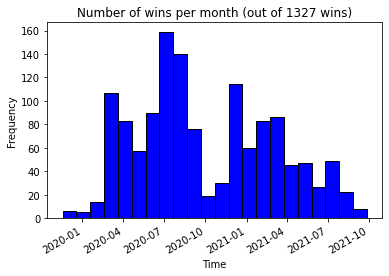

In [35]:
#plot distribution of wins across time as histogram
chess_data_win = chess_data[chess_data['result'] == 'win']
sample_size_win = len(chess_data_win.index)

plt.hist(chess_data_win['time'], color = 'blue', edgecolor = 'black', bins = total_month_difference)
plt.title(f'Number of wins per month (out of {sample_size_win} wins)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate() #make X axis look better with dates
plt.show;

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2715 entries, 0 to 2714
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   time                    2715 non-null   datetime64[ns]
 1   end_time                2715 non-null   datetime64[ns]
 2   result                  2715 non-null   object        
 3   colour                  2715 non-null   object        
 4   reason                  2715 non-null   object        
 5   white_elo               2715 non-null   int64         
 6   black_elo               2715 non-null   int64         
 7   opening                 2715 non-null   object        
 8   EC0                     2715 non-null   object        
 9   game_length_s           2715 non-null   int64         
 10  game_length_m           2715 non-null   float64       
 11  game_id                 2715 non-null   int64         
 12  my_elo                  2715 non-null   int64   

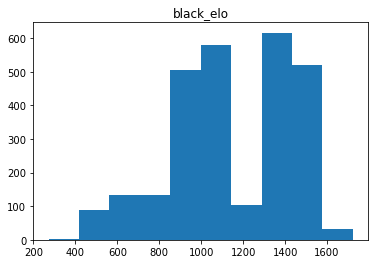

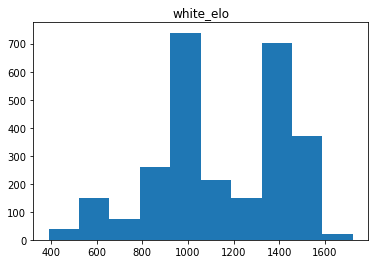

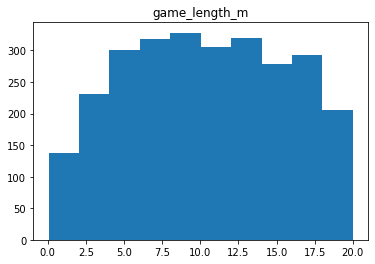

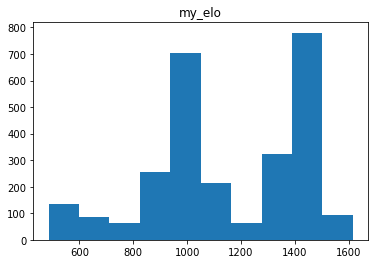

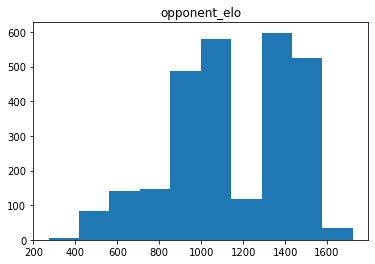

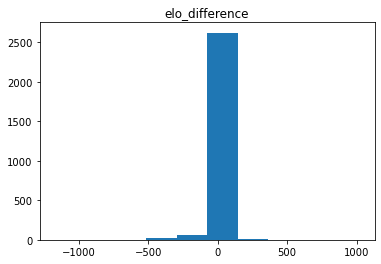

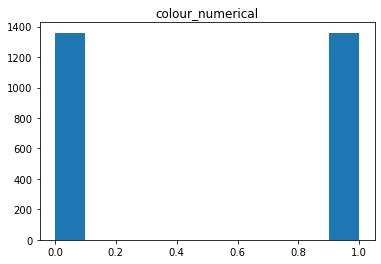

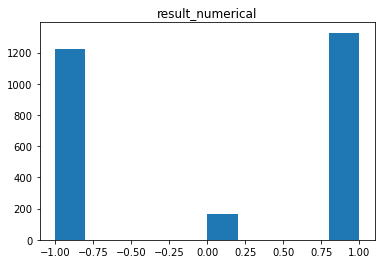

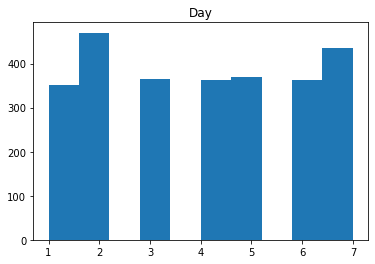

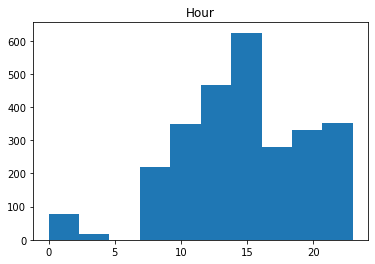

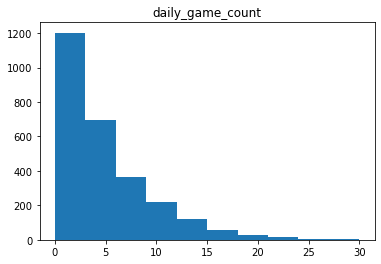

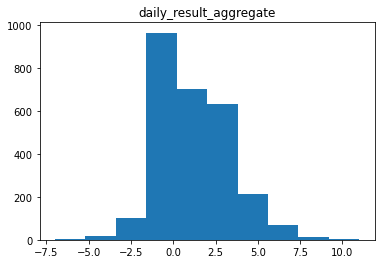

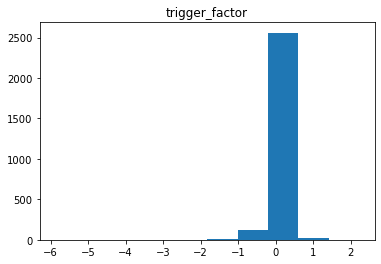

In [36]:
#histograms for all numerical columns
chess_data.info()

df_num = chess_data[['black_elo', 'white_elo','game_length_m', 'my_elo', 'opponent_elo', 'elo_difference', 'colour_numerical', 'result_numerical', 'Day', 'Hour', 'daily_game_count', 'daily_result_aggregate', 'trigger_factor']]

for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()



In [37]:
pd.pivot_table(chess_data, index = 'result_numerical', values = ['my_elo', 'elo_difference', 'Hour'])

,Hour,elo_difference,my_elo
result_numerical,,,
-1,14.722131,21.784426,1143.659016
0,15.142857,-2.642857,1194.315476
1,14.470987,-27.967596,1151.245667


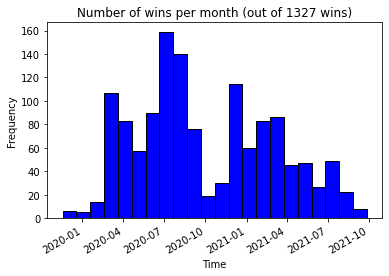

In [38]:
#Win rate per month

chess_data_win = chess_data[chess_data['result'] == 'win']
sample_size_win = len(chess_data_win.index)

plt.hist(chess_data_win['time'], color = 'blue', edgecolor = 'black', bins = total_month_difference)
plt.title(f'Number of wins per month (out of {sample_size_win} wins)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate() #make X axis look better with dates
plt.show;

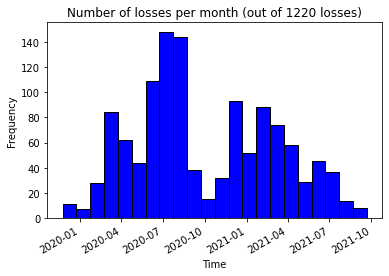

In [39]:
#plot distribution of losses across time as histogram
chess_data_loss = chess_data[chess_data['result'] == 'loss']
sample_size_loss = len(chess_data_loss.index)

plt.hist(chess_data_loss['time'], color = 'blue', edgecolor = 'black', bins = total_month_difference)
plt.title(f'Number of losses per month (out of {sample_size_loss} losses)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate() #make X axis look better with dates
plt.show;

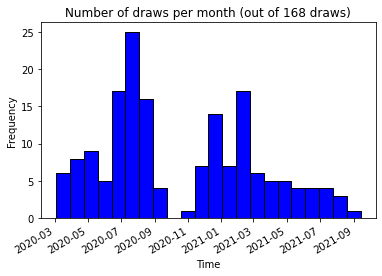

In [40]:
#plot distribution of draws across time as histogram
chess_data_draw = chess_data[chess_data['result'] == 'draw']
sample_size_draw = len(chess_data_draw.index)

plt.hist(chess_data_draw['time'], color = 'blue', edgecolor = 'black', bins = total_month_difference)
plt.title(f'Number of draws per month (out of {sample_size_draw} draws)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate() #make X axis look better with dates
plt.show;

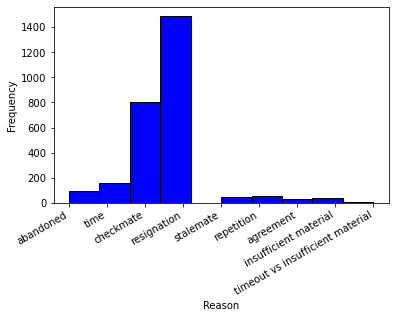

In [41]:
#plot bar chart of number of reasons for win/loss

plt.hist(chess_data['reason'], color = 'blue', edgecolor = 'black')

plt.xlabel('Reason')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate()

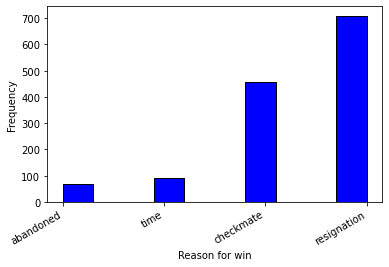

In [42]:
plt.hist(chess_data_win['reason'], color = 'blue', edgecolor = 'black')

plt.xlabel('Reason for win')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate()

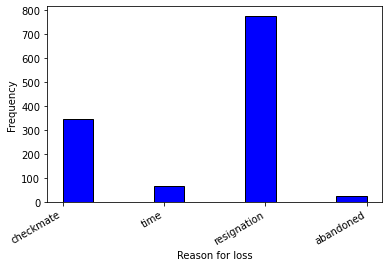

In [43]:
plt.hist(chess_data_loss['reason'], color = 'blue', edgecolor = 'black')

plt.xlabel('Reason for loss')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate()

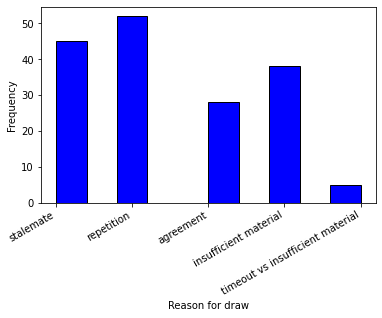

In [44]:
plt.hist(chess_data_draw['reason'], color = 'blue', edgecolor = 'black')

plt.xlabel('Reason for draw')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate()

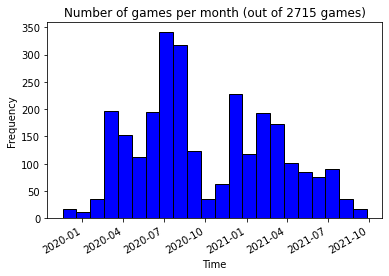

In [45]:
#plot distribution of games across time as histogram

sample_size = len(chess_data.index)

plt.hist(chess_data['time'], color = 'blue', edgecolor = 'black', bins = total_month_difference)
plt.title(f'Number of games per month (out of {sample_size} games)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.gcf().autofmt_xdate() #make X axis look better with dates
plt.show;

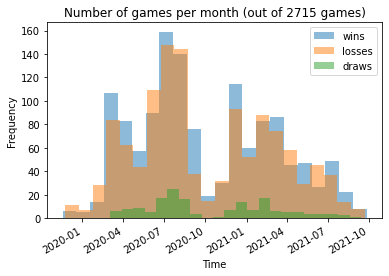

In [46]:
# Wins/loss/draws on one histograms
plt.hist(chess_data_win['time'], alpha=0.5, label='wins', bins = total_month_difference)
plt.hist(chess_data_loss['time'], alpha=0.5, label='losses', bins = total_month_difference )
plt.hist(chess_data_draw['time'], alpha=0.5, label = 'draws', bins = total_month_difference)
plt.title(f'Number of games per month (out of {sample_size} games)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.gcf().autofmt_xdate()
plt.show();

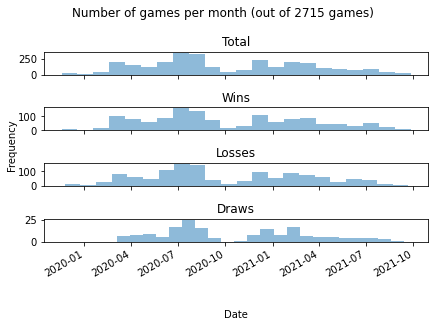

In [47]:
# # Wins/loss/draws using subplots

fig, axs = plt.subplots(4, sharex=True)

axs[0].hist(chess_data['time'], alpha=0.5, label='Games', bins = total_month_difference)
axs[1].hist(chess_data_win['time'], alpha=0.5, label='wins', bins = total_month_difference)
axs[2].hist(chess_data_loss['time'], alpha=0.5, label='losses', bins = total_month_difference)
axs[3].hist(chess_data_draw['time'], alpha=0.5, label = 'draws', bins = total_month_difference)

plt.suptitle(f'Number of games per month (out of {sample_size} games)')

axs[0].set_title('Total')
axs[1].set_title('Wins')
axs[2].set_title('Losses')
axs[3].set_title('Draws')

plt.gcf().autofmt_xdate()
fig.tight_layout()
fig.text(0.53, -0.1, 'Date', ha='center')
fig.text(0.00, 0.5, 'Frequency', va='center', rotation='vertical')
plt.show();

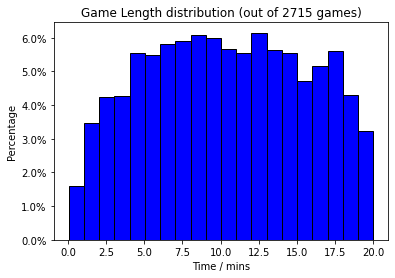

In [48]:
#plot distribution of game lengths
histogram = plt.hist(chess_data['game_length_m'], weights=np.ones(chess_data.game_length_m.count()) / chess_data.game_length_m.count(), color = 'blue', edgecolor = 'black', bins = 20)

plt.title(f'Game Length distribution (out of {sample_size} games)')
plt.xlabel('Time / mins')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1));

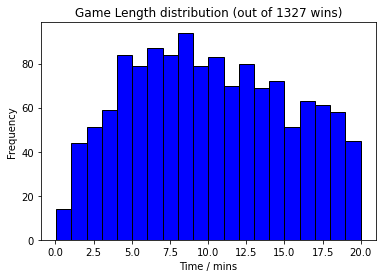

In [49]:
#plot histogram of game length distribution for WINS only

chess_data_win = chess_data[chess_data['result'] == 'win'] # dataframe only with win rows included
sample_size_wins = len(chess_data_win.index)


histogram = plt.hist(chess_data_win['game_length_m'], color = 'blue', edgecolor = 'black', bins = 20)

plt.title(f'Game Length distribution (out of {sample_size_wins} wins)')
plt.xlabel('Time / mins')
plt.ylabel('Frequency')
plt.show;

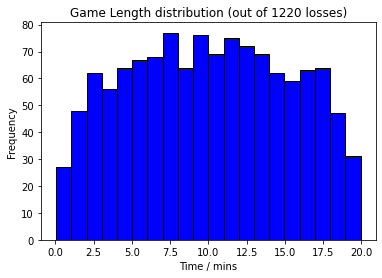

In [50]:
#plot histogram of game length distribution for LOSSES only

chess_data_loss = chess_data[chess_data['result'] == 'loss'] # dataframe only with win rows included
sample_size_loss = len(chess_data_loss.index)

histogram = plt.hist(chess_data_loss['game_length_m'], color = 'blue', edgecolor = 'black', bins = 20)

plt.title(f'Game Length distribution (out of {sample_size_loss} losses)')
plt.xlabel('Time / mins')
plt.ylabel('Frequency')
plt.show;

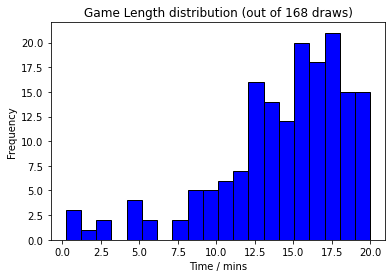

In [51]:
#plot histogram of game length distribution for DRAWS only

chess_data_draw = chess_data[chess_data['result'] == 'draw'] # dataframe only with win rows included
sample_size_draw = len(chess_data_draw.index)

histogram = plt.hist(chess_data_draw['game_length_m'], color = 'blue', edgecolor = 'black', bins = 20)

plt.title(f'Game Length distribution (out of {sample_size_draw} draws)')
plt.xlabel('Time / mins')
plt.ylabel('Frequency')
plt.show;

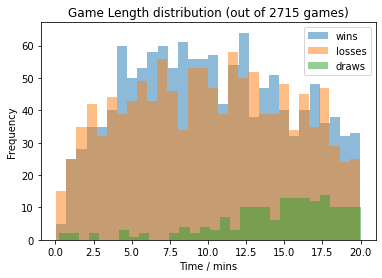

In [52]:
# Wins/loss/draws on one histograms

plt.hist(chess_data_win['game_length_m'], alpha=0.5, label='wins', bins = 30)
plt.hist(chess_data_loss['game_length_m'], alpha=0.5, label='losses', bins = 30 )
plt.hist(chess_data_draw['game_length_m'], alpha=0.5, label = 'draws', bins = 30)
plt.title(f'Game Length distribution (out of {sample_size} games)')
plt.xlabel('Time / mins')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show();

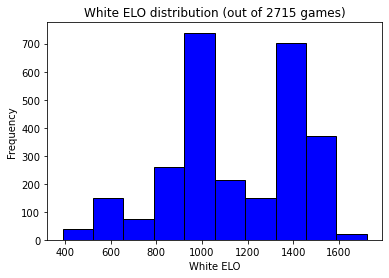

In [53]:
#plot distribution of white_elo

graph = plt.hist(chess_data['white_elo'], color = 'blue', edgecolor = 'black', bins = 10)
plt.title(f'White ELO distribution (out of {sample_size} games)')
plt.xlabel('White ELO')
plt.ylabel('Frequency')
plt.gcf()
plt.show;

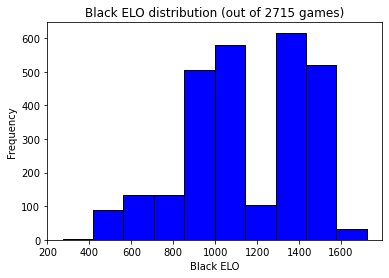

In [54]:
#plot distribution of black_elo

graph = plt.hist(chess_data['black_elo'], color = 'blue', edgecolor = 'black', bins = 10)
plt.title(f'Black ELO distribution (out of {sample_size} games)')
plt.xlabel('Black ELO')
plt.ylabel('Frequency')
plt.gcf()
plt.show;

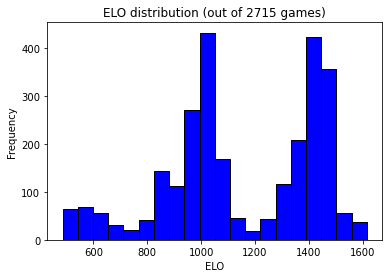

In [55]:
#plot distribution of my ELO

graph = plt.hist(chess_data['my_elo'], color = 'blue', edgecolor = 'black', bins = 20)
plt.title(f'ELO distribution (out of {sample_size} games)')
plt.xlabel('ELO')
plt.ylabel('Frequency')
plt.show;

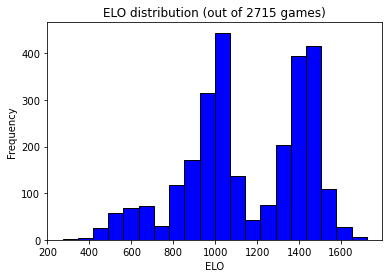

In [56]:
#plot distribution of opponent's elo

graph = plt.hist(chess_data['opponent_elo'], color = 'blue', edgecolor = 'black', bins = 20)
plt.title(f'ELO distribution (out of {sample_size} games)')
plt.xlabel('ELO')
plt.ylabel('Frequency')
plt.show;

In [57]:
#Making win/loss/draw rates for each day
chess_results_by_day = chess_data.groupby(by='Day').result_numerical.value_counts()
chess_games_by_day = chess_data.groupby(by='Day').result_numerical.count()

list_games = []
list_win_rate = []
list_wins = []

list_loss_rate = []
list_losses = []

list_draw_rate = []
list_draws = []

for x in range(1,8):
    list_wins.append(chess_results_by_day[x][1])
    list_games.append(chess_games_by_day[x])
    list_win_rate.append(round(chess_results_by_day[x][1] / chess_games_by_day[x], 3))
    
for x in range(1,8):
    list_losses.append(chess_results_by_day[x][-1])
    list_loss_rate.append(round(chess_results_by_day[x][-1] / chess_games_by_day[x], 3))

for x in range(1,8):
    list_draws.append(chess_results_by_day[x][0])
    list_draw_rate.append(round(chess_results_by_day[x][0] / chess_games_by_day[x], 3))
    


In [58]:
chess_games_by_day

Day
1    352
2    470
3    364
4    362
5    369
6    363
7    435
Name: result_numerical, dtype: int64

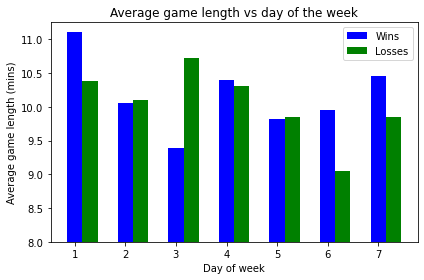

In [59]:
# create plot
fig, ax = plt.subplots()
bar_width = 0.3
index = np.arange(1,8)

rects1 = plt.bar(index, chess_data_win.groupby(by='Day').mean().game_length_m, 
color='b', width=bar_width, label='Wins')

rects2 = plt.bar(index + bar_width, chess_data_loss.groupby(by='Day').mean().game_length_m,
color='g', width=bar_width,label='Losses')


plt.xlabel('Day of week')
plt.ylabel('Average game length (mins)')
plt.title('Average game length vs day of the week')
# plt.xticks()
plt.legend()
plt.ylim([8, 11.25])
plt.tight_layout()
plt.show()


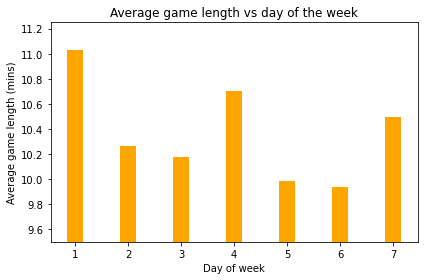

In [60]:
# create plot
fig, ax = plt.subplots()
bar_width = 0.3
index = np.arange(1, 8)

rects4 = plt.bar(index, chess_data.groupby(by='Day').mean().game_length_m,
color='orange',  width=bar_width)

plt.xlabel('Day of week')
plt.ylabel('Average game length (mins)')
plt.title('Average game length vs day of the week')
plt.ylim([9.5, 11.25])
plt.tight_layout()
plt.show()


In [61]:
#Making win/loss/draw rates for each hour
chess_games_by_hour = chess_data.groupby(by='Hour').result_numerical.count()
chess_results_by_hour = chess_data.groupby(by='Hour').result_numerical.value_counts()
hours_played = chess_games_by_hour.index.tolist()

hour_result_list = []
hour_win_list = []
hour_loss_list = []
hour_draw_list = []
for x in chess_results_by_hour.index:
    for y in hours_played:
        if y == x[0]:
            hour_result_list.append([y,x[1]])

list_hour_games = []
list_hour_win_rate = []
list_hour_wins = []

list_hour_loss_rate = []
list_hour_losses = []

list_hour_draw_rate = []
list_hour_draws = []


for x, y in hour_result_list:
    
    if y == 1:
        list_hour_wins.append(chess_results_by_hour[x][y])
        list_hour_games.append(chess_games_by_hour[x])
        list_hour_win_rate.append(round(chess_results_by_hour[x][y] / chess_games_by_hour[x], 3))
        hour_win_list.append(x)
        
    elif y == 0:
        list_hour_draws.append(chess_results_by_hour[x][y])
        list_hour_draw_rate.append(round(chess_results_by_hour[x][y] / chess_games_by_hour[x], 3))
        hour_draw_list.append(x)

    elif y == -1:
        list_hour_losses.append(chess_results_by_hour[x][y])
        list_hour_loss_rate.append(round(chess_results_by_hour[x][y] / chess_games_by_hour[x], 3))
        hour_loss_list.append(x)
        
# print(list_hour_win_rate)
# print(list_hour_loss_rate)
# print(list_hour_draw_rate)


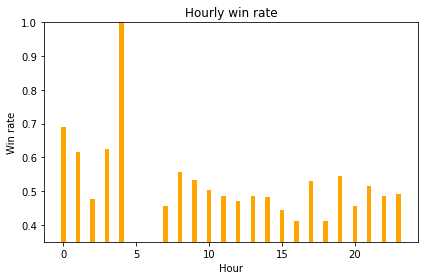

In [62]:
# win rate vs hour of day
fig, ax = plt.subplots()
bar_width = 0.3


rects1 = plt.bar(hour_win_list, list_hour_win_rate,
color='orange',  width=bar_width)

plt.xlabel('Hour')
plt.ylabel('Win rate')
plt.title('Hourly win rate')
plt.ylim(0.35, 1)
plt.tight_layout()
plt.show()

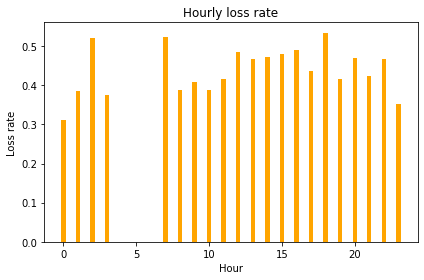

In [63]:
#loss rate vs hour of day

fig, ax = plt.subplots()
bar_width = 0.3

rects1 = plt.bar(hour_loss_list, list_hour_loss_rate,
color='orange',  width=bar_width)

plt.xlabel('Hour')
plt.ylabel('Loss rate')
plt.title('Hourly loss rate')
# plt.ylim()
plt.tight_layout()
plt.show()

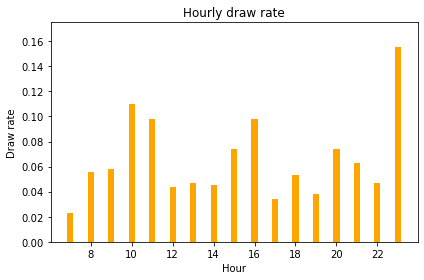

In [64]:
#Draw rate vs hour in day
fig, ax = plt.subplots()
bar_width = 0.3


rects1 = plt.bar(hour_draw_list, list_hour_draw_rate,
color='orange',  width=bar_width)

plt.xlabel('Hour')
plt.ylabel('Draw rate')
plt.title('Hourly draw rate')
plt.ylim(0, 0.175)
plt.tight_layout()
plt.show()

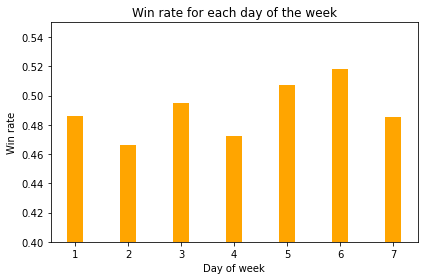

In [65]:
# win rate vs day of week
fig, ax = plt.subplots()
bar_width = 0.3
index = np.arange(1,8)

rects1 = plt.bar(index, list_win_rate,
color='orange',  width=bar_width)

plt.xlabel('Day of week')
plt.ylabel('Win rate')
plt.title('Win rate for each day of the week')
plt.ylim([0.4, 0.55])
plt.tight_layout()
plt.show()

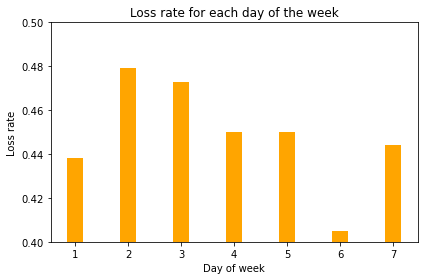

In [66]:
# create plot
fig, ax = plt.subplots()
bar_width = 0.3
index = np.arange(1,8)

rects1 = plt.bar(index, list_loss_rate,
color='orange',  width=bar_width)

plt.xlabel('Day of week')
plt.ylabel('Loss rate')
plt.title('Loss rate for each day of the week')
plt.ylim([0.4, 0.5])
plt.tight_layout()
plt.show()

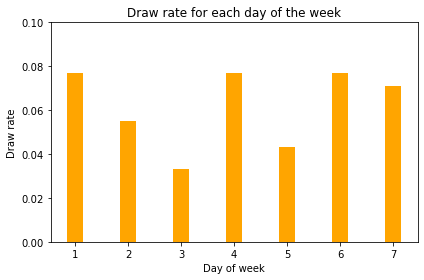

In [67]:
# create plot
fig, ax = plt.subplots()
bar_width = 0.3
index = np.arange(1,8)

rects1 = plt.bar(index, list_draw_rate,
color='orange',  width=bar_width)

plt.xlabel('Day of week')
plt.ylabel('Draw rate')
plt.title('Draw rate for each day of the week')
plt.ylim([0, 0.1])
plt.tight_layout()
plt.show()

<ipython-input-68-99b24c7183cd>:12: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  plt.axhline(y=chess_data.mean().daily_game_count, color='r', linestyle='--')


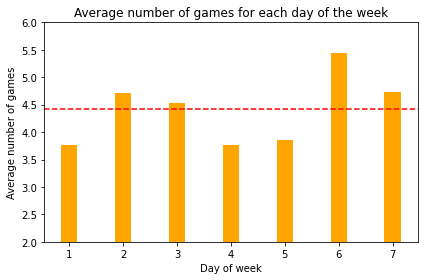

In [68]:
# create plot
fig, ax = plt.subplots()
bar_width = 0.3
index = np.arange(1,8)

rects1 = plt.bar(index, chess_data.groupby(by='Day').mean().daily_game_count,
color='orange',  width=bar_width)

plt.xlabel('Day of week')
plt.ylabel('Average number of games')
plt.title('Average number of games for each day of the week')
plt.axhline(y=chess_data.mean().daily_game_count, color='r', linestyle='--')
plt.ylim([2, 6])
plt.tight_layout()
plt.show()

<ipython-input-69-ef8aaee9317b>:11: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  plt.axhline(y=chess_data.mean().elo_difference, color='r', linestyle='--')


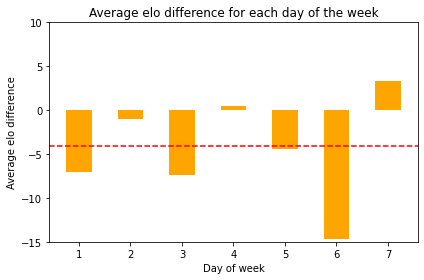

In [69]:
# Average elo difference for each day of the week
fig, ax = plt.subplots()
bar_width = 0.5
index = np.arange(1,8)

rects1 = plt.bar(index, chess_data.groupby(by='Day').mean().elo_difference, color='orange', width=bar_width)

plt.xlabel('Day of week')
plt.ylabel('Average elo difference')
plt.title('Average elo difference for each day of the week')
plt.axhline(y=chess_data.mean().elo_difference, color='r', linestyle='--')
plt.ylim([-15,10])
plt.tight_layout()
plt.show()

<ipython-input-70-983dccc97202>:11: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  plt.axhline(y=chess_data.mean().result_numerical, color='r', linestyle='--')


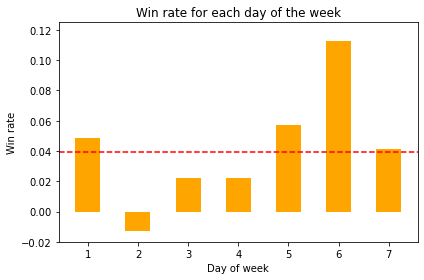

In [70]:
# average win rate for each day of week
fig, ax = plt.subplots()
bar_width = 0.5
index = np.arange(1,8)

rects1 = plt.bar(index, chess_data.groupby(by='Day').mean().result_numerical, color='orange', width=bar_width)

plt.xlabel('Day of week')
plt.ylabel('Win rate')
plt.title('Win rate for each day of the week')
plt.axhline(y=chess_data.mean().result_numerical, color='r', linestyle='--')
plt.ylim([-0.02,0.125])
plt.tight_layout()
plt.show()

<ipython-input-71-3174269da3a9>:12: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  plt.axhline(y=chess_data.mean().daily_game_count, color='r', linestyle='--')


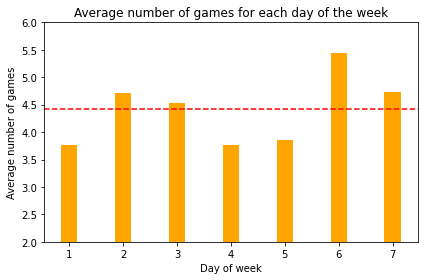

In [71]:
# Average number of games for each day of the week
fig, ax = plt.subplots()
bar_width = 0.3
index = np.arange(1,8)

rects1 = plt.bar(index, chess_data.groupby(by='Day').mean().daily_game_count,
color='orange',  width=bar_width)

plt.xlabel('Day of week')
plt.ylabel('Average number of games')
plt.title('Average number of games for each day of the week')
plt.axhline(y=chess_data.mean().daily_game_count, color='r', linestyle='--')
plt.ylim([2, 6])
plt.tight_layout()
plt.show()

In [72]:
game_length_by_hour = chess_data.groupby(by='Hour').mean().game_length_m
game_length_by_hour = pd.DataFrame(game_length_by_hour)
game_length_by_hour['Hour'] = game_length_by_hour.index
game_length_by_hour


,game_length_m,Hour
Hour,,
0,11.236667,0
1,9.528462,1
2,8.094348,2
3,6.853125,3
4,16.430000,4
7,10.407273,7
8,10.993148,8
9,11.361583,9
10,11.235742,10


In [73]:
# unique_hours_with_games = []
# test_test_list = []
# for x in hour_result_list:
#     test_test_list.append(hour_result_list[x][0])
# # unique_hours_with_games = set(test_test_list)
# # unique_hours_with_games
# test_test_list



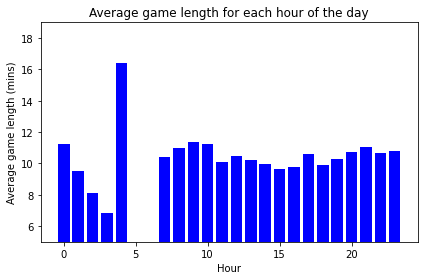

In [74]:
# Hour vs avg game length
# Average number of games for each day of the week

plt.bar(game_length_by_hour['Hour'], game_length_by_hour['game_length_m'], label='My ELO', color = 'blue')

# plt(game_length_by_hour)

plt.xlabel('Hour')
plt.ylabel('Average game length (mins)')
plt.title('Average game length for each hour of the day')

plt.ylim([5, 19])
plt.tight_layout()
plt.show()

In [135]:
#I want a dataframe which counts number of games of each EC0, and also counts the number of wins, losses, draws, 
#then also the percentage of wins, loss, draws.
chess_data.groupby(by='EC0').mean()

,white_elo,black_elo,game_length_s,game_length_m,game_id,my_elo,opponent_elo,elo_difference,colour_numerical,result_numerical,...,Hour,Minute,Second,daily_game_count,daily_result_aggregate,Previous_result,length_of_last_game,time_since_last_game_m,trigger_factor,my_elo_av
EC0,,,,,,,,,,,,,,,,,,,,,
A00,1015.574468,1021.446809,643.968085,10.732766,1040.840426,1031.776596,1005.244681,-26.531915,0.085106,0.095745,...,14.585106,27.904255,28.287234,3.882979,1.223404,0.031915,10.111809,676.069362,-0.032369,1022.119504
A01,1166.714286,1169.357143,706.571429,11.776429,1399.571429,1169.357143,1166.714286,-2.642857,0.000000,0.071429,...,16.000000,25.857143,29.571429,3.857143,0.714286,0.142857,11.815714,806.087143,0.035671,1127.897436
A02,824.333333,819.000000,694.333333,11.573333,840.000000,819.000000,824.333333,5.333333,0.000000,-0.333333,...,11.333333,25.333333,37.333333,0.000000,0.000000,-0.333333,16.906667,1509.356667,-0.000264,831.100000
A03,1306.200000,1309.600000,548.200000,9.136000,1729.400000,1309.600000,1306.200000,-3.400000,0.000000,-0.200000,...,17.600000,32.600000,17.000000,6.600000,2.000000,0.200000,7.846000,179.810000,0.068373,1304.220000
A04,640.000000,637.500000,858.500000,14.310000,178.000000,637.500000,640.000000,2.500000,0.000000,0.500000,...,18.500000,31.000000,38.500000,4.500000,0.500000,1.000000,4.335000,7.695000,0.192027,659.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D70,1423.000000,1450.000000,453.000000,7.550000,2453.000000,1423.000000,1450.000000,27.000000,1.000000,-1.000000,...,10.000000,40.000000,31.000000,0.000000,0.000000,1.000000,3.570000,2290.330000,0.000437,1465.700000
E00,1480.000000,1446.000000,852.000000,14.200000,2176.000000,1446.000000,1480.000000,34.000000,0.000000,-1.000000,...,20.000000,53.000000,20.000000,13.000000,1.000000,-1.000000,4.070000,233.770000,-0.004278,1414.333333
E10,1435.000000,1389.000000,562.000000,9.370000,2124.000000,1435.000000,1389.000000,-46.000000,1.000000,1.000000,...,19.000000,14.000000,29.000000,0.000000,0.000000,-1.000000,7.930000,1280.630000,-0.000781,1417.700000


In [133]:
#Openings i'm most likely to play when having a good chess day and a bad chess day
EC0_vs_aggregate_result = pd.DataFrame(chess_data.groupby(by='EC0').mean().daily_result_aggregate)
EC0_vs_aggregate_result['EC0'] = EC0_vs_aggregate_result.index
EC0_vs_aggregate_result
opening_played_most_on_best_days = EC0_vs_aggregate_result.max()
opening_played_most_on_worst_days = EC0_vs_aggregate_result.min()

print('opening played most on best days')
opening_played_most_on_best_days
print('opening played most on worst days')
opening_played_most_on_worst_days

,daily_result_aggregate,EC0
EC0,,
A00,1.223404,A00
A01,0.714286,A01
A02,0.000000,A02
A03,2.000000,A03
A04,0.500000,A04
...,...,...
D70,0.000000,D70
E00,1.000000,E00
E10,0.000000,E10


opening played most on best days


daily_result_aggregate    4.0
EC0                       E60
dtype: object

opening played most on worst days


daily_result_aggregate   -2.0
EC0                       A00
dtype: object

In [359]:
#Avg result for each opening
pd.DataFrame(chess_data.groupby(by='EC0').mean().result_numerical)

EC0_vs_result = pd.DataFrame(chess_data.groupby(by='EC0').mean().result_numerical)
EC0_vs_result['percentage_of_games'] = (chess_data['EC0'].value_counts()  * 100 / chess_data.shape[0])
mask = (EC0_vs_result.percentage_of_games > 0.5) # only look at openings which have been played more than 0.5% of games
display(EC0_vs_result[mask].result_numerical.max(), 'Best Avg result of opening')
display(EC0_vs_result[mask].result_numerical.min(), 'Worst Avg result of opening')
display(EC0_vs_result[mask].sort_values(by='percentage_of_games', ascending=False).iloc[0:1, 0:2], 'Most played opening')
display(EC0_vs_result[mask].sort_values(by='percentage_of_games', ascending=True).iloc[0:1, 0:2], 'Least played opening')
display(EC0_vs_result[mask].sort_values(by='result_numerical', ascending=False).iloc[0:1, 0:2], 'Best opening')
display(EC0_vs_result[mask].sort_values(by='result_numerical', ascending=True).iloc[0:1, 0:2], 'Worst opening')

,result_numerical
EC0,
A00,0.095745
A01,0.071429
A02,-0.333333
A03,-0.200000
A04,0.500000
...,...
D70,-1.000000
E00,-1.000000
E10,1.000000


0.5185185185185185

'Best Avg result of opening'

-0.34285714285714286

'Worst Avg result of opening'

,result_numerical,percentage_of_games
EC0,,
B01,0.048387,9.134438


'Most played opening'

,result_numerical,percentage_of_games
EC0,,
A01,0.071429,0.515654


'Least played opening'

,result_numerical,percentage_of_games
EC0,,
C47,0.518519,0.994475


'Best opening'

,result_numerical,percentage_of_games
EC0,,
B20,-0.342857,1.289134


'Worst opening'

In [91]:
EC0_vs_result['EC0'] = EC0_vs_result.index
elo_input = int(input('Please enter minimum elo of games to look at for different openings '))
mask_min_elo = chess_data['my_elo'] > elo_input

Please enter minimum elo of games to look at for different openings 1400


In [265]:
# Table of openings with their count of times played and average result - only showing openings which have been played
# at east 0.5% of the time for given elo
# Also including my average ELO for each opening to get a sense of where in my chess career I most played it

opening_counts = chess_data[['opening','EC0']][mask_min_elo].value_counts()
opening_vs_result_mean = chess_data[['opening','result_numerical', 'EC0', 'my_elo', 'colour_numerical','game_length_m']][mask_min_elo].groupby(by = 'opening').mean()
opening_counts = pd.DataFrame(opening_counts)
opening_counts = opening_counts.reset_index()
opening_results = pd.merge(opening_counts, opening_vs_result_mean, on="opening")
opening_results = opening_results.rename(columns={0:'Count'})
opening_results_mask = (opening_results.Count > (chess_data[mask_min_elo].shape[0] / 200))
print(f'Dataframe of openings for games above {elo_input} elo')
display(opening_results.reset_index(drop=True))

#15 best openings
print(f'Best 15 openings for games above {elo_input} elo')
display(opening_results[opening_results_mask].sort_values(by='result_numerical', ascending=False).head(15).reset_index(drop=True))

#15 worst openings
print(f'Worst 15 openings for games above {elo_input} elo')
display(opening_results[opening_results_mask].sort_values(by='result_numerical', ascending=False).tail(15).reset_index(drop=True))

Dataframe of openings for games above 1400 elo


,opening,EC0,Count,result_numerical,my_elo,colour_numerical,game_length_m
0,French-Defense-Normal-Variation,C00,52,0.153846,1478.634615,1.000000,11.450000
1,Caro-Kann-Defense-2.Nf3-d5,B10,26,0.038462,1455.423077,0.000000,12.907692
2,Queens-Pawn-Opening-Accelerated-London-System,D00,24,-0.333333,1459.458333,0.000000,8.356250
3,Slav-Defense-3.Nc3,D10,18,0.111111,1473.055556,0.833333,11.395000
4,Queens-Gambit-Accepted-Central-Variation,D20,17,0.411765,1457.647059,1.000000,9.632353
...,...,...,...,...,...,...,...
286,Modern-Defense-Standard-Two-Knights-Variation,B06,1,1.000000,1409.000000,1.000000,6.430000
287,Modern-Defense-with-1-e4-2.d4-d6-3.Nf3,B07,1,0.000000,1430.000000,1.000000,14.970000
288,Neo-Grunfeld-Defense,D70,1,-1.000000,1423.000000,1.000000,7.550000
289,Nimzowitsch-Defense-2.d4,B00,1,1.000000,1424.000000,1.000000,18.480000


Best 15 openings for games above 1400 elo


,opening,EC0,Count,result_numerical,my_elo,colour_numerical,game_length_m
0,Kings-Fianchetto-Opening-1...e5-2.Bg2-d5,A00,5,0.800000,1430.000000,0.000000,12.224000
1,Queens-Pawn-Opening-1...d5-2.e3-Nf6,D00,6,0.666667,1480.833333,0.000000,15.955000
2,Queens-Gambit-Accepted-Central-Variation-Moder...,D20,8,0.625000,1471.750000,1.000000,12.420000
3,Giuoco-Piano-Game-Giuoco-Pianissimo-Italian-Fo...,C50,5,0.600000,1452.400000,0.000000,13.748000
4,Ruy-Lopez-Opening-Morphy-Defense-Exchange-Vari...,C68,8,0.500000,1445.000000,0.000000,11.046250
5,Queens-Gambit-Accepted-Central-Variation,D20,17,0.411765,1457.647059,1.000000,9.632353
6,Queens-Gambit-Accepted-Central-Variation-McDon...,D20,7,0.285714,1449.285714,1.000000,11.141429
7,Caro-Kann-Defense-Hillbilly-Attack-2...d5,B10,9,0.222222,1455.333333,0.000000,9.224444
8,Caro-Kann-Defense-2.Nc3-d5,B10,5,0.200000,1448.200000,0.000000,8.434000
9,Slav-Defense,D10,5,0.200000,1453.600000,0.800000,13.964000


Worst 15 openings for games above 1400 elo


,opening,EC0,Count,result_numerical,my_elo,colour_numerical,game_length_m
0,Caro-Kann-Defense-Advance-Botvinnik-Carls-Defense,B12,7,-0.142857,1430.000000,0.000000,11.598571
1,Italian-Game-Anti-Fried-Liver-Defense,C55,6,-0.166667,1424.666667,1.000000,9.188333
2,Italian-Game,C50,6,-0.166667,1424.833333,1.000000,11.441667
3,Queens-Gambit-Declined-Harrwitz-Attack,D35,5,-0.200000,1481.200000,0.800000,6.394000
4,Queens-Gambit-Declined-Marshall-Defense,D06,5,-0.200000,1453.600000,1.000000,10.884000
5,Kings-Pawn-Opening-Kings-Knight-Variation-2...Nc6,C44,5,-0.200000,1450.400000,0.000000,13.726000
6,Scotch-Game...4.Nxd4-Nxd4-5.Qxd4-d6,C45,10,-0.200000,1475.500000,0.000000,7.222000
7,Giuoco-Piano-Game-4.O-O-Nf6,C50,13,-0.230769,1452.692308,0.153846,12.425385
8,Giuoco-Piano-Game-Main-Line-Albin-Gambit,C53,7,-0.285714,1443.142857,0.000000,8.450000
9,Vant-Kruijs-Opening-1...e5,A00,6,-0.333333,1437.833333,0.000000,13.646667


In [267]:
#SAME idea as above but using EC0 only to get broader idea (instead of looking at individual opening names)
EC0_counts = chess_data[['EC0']][mask_min_elo].value_counts()
EC0_vs_result_mean = chess_data[['result_numerical', 'EC0', 'my_elo', 'colour_numerical','game_length_m']][mask_min_elo].groupby(by ='EC0').mean()
EC0_counts = pd.DataFrame(EC0_counts)
EC0_counts = EC0_counts.reset_index()
EC0_results = pd.merge(EC0_counts, EC0_vs_result_mean, on="EC0")
EC0_results = EC0_results.rename(columns={0:'Count'})
EC0_results_mask = (EC0_results.Count > (chess_data[mask_min_elo].shape[0] / 200))

print(f'Dataframe of ECO openings for games above {elo_input} elo')
display(EC0_results.reset_index(drop=True))

#15 best ECO openings
print(f'Best 15 ECO openings for games above {elo_input} elo')
display(EC0_results[EC0_results_mask].sort_values(by='result_numerical', ascending=False).head(15).reset_index(drop=True))

#15 worst ECO openings
print(f'Worst 15 ECO openings for games above {elo_input} elo')
display(EC0_results[EC0_results_mask].sort_values(by='result_numerical', ascending=False).tail(15).reset_index(drop=True))

Dataframe of ECO openings for games above 1400 elo


,EC0,Count,result_numerical,my_elo,colour_numerical,game_length_m
0,D20,55,0.345455,1463.800000,1.000000,10.828182
1,B10,54,-0.055556,1449.666667,0.000000,11.361667
2,C00,53,0.132075,1477.584906,1.000000,11.472075
3,C50,45,-0.088889,1453.022222,0.288889,10.906889
4,D00,44,-0.113636,1459.227273,0.045455,9.809318
...,...,...,...,...,...,...
83,D15,1,1.000000,1614.000000,0.000000,4.670000
84,C58,1,-1.000000,1448.000000,1.000000,9.570000
85,C78,1,-1.000000,1506.000000,0.000000,13.750000
86,C80,1,1.000000,1490.000000,0.000000,6.570000


Best 15 ECO openings for games above 1400 elo


,EC0,Count,result_numerical,my_elo,colour_numerical,game_length_m
0,D53,5,0.600000,1431.400000,0.600000,11.230000
1,A46,8,0.500000,1451.625000,1.000000,10.861250
2,A48,9,0.444444,1503.777778,1.000000,12.310000
3,A40,16,0.375000,1488.750000,1.000000,12.688125
4,D20,55,0.345455,1463.800000,1.000000,10.828182
5,C41,12,0.333333,1435.000000,1.000000,12.250833
6,C70,6,0.333333,1482.000000,0.000000,12.736667
7,C54,7,0.285714,1491.857143,0.000000,11.582857
8,B01,7,0.285714,1434.714286,1.000000,13.310000
9,C20,20,0.250000,1454.750000,0.050000,11.573000


Worst 15 ECO openings for games above 1400 elo


,EC0,Count,result_numerical,my_elo,colour_numerical,game_length_m
0,C40,6,0.000000,1415.000000,1.000000,15.938333
1,A00,21,0.000000,1451.285714,0.095238,11.637143
2,B10,54,-0.055556,1449.666667,0.000000,11.361667
3,C50,45,-0.088889,1453.022222,0.288889,10.906889
4,D00,44,-0.113636,1459.227273,0.045455,9.809318
5,C53,18,-0.166667,1454.333333,0.111111,11.365556
6,C30,5,-0.200000,1441.400000,0.000000,5.480000
7,C55,9,-0.222222,1435.111111,0.777778,9.552222
8,C45,13,-0.230769,1471.076923,0.000000,7.357692
9,B22,8,-0.250000,1436.750000,1.000000,11.296250


In [268]:
#First move success
mask_white = chess_data['colour'] == 'White'
mask_min_elo_white = (chess_data['my_elo'] > elo_input) & (chess_data['colour'] == 'White')

first_move_frame = chess_data[mask_white].groupby(by='first_move').mean()[['game_length_m', 'my_elo', 'result_numerical', 'elo_difference', 'daily_game_count', 'Hour', 'Previous_result']]
first_move_frame['count'] = chess_data[mask_white].first_move.value_counts()
print(f'My white first move statistics:')
first_move_frame

first_move_frame_min_elo = chess_data[mask_min_elo_white].groupby(by='first_move').mean()[['game_length_m', 'my_elo', 'result_numerical', 'elo_difference', 'daily_game_count', 'Hour', 'Previous_result']]
first_move_frame_min_elo['count'] = chess_data[mask_min_elo_white].first_move.value_counts()
print(f'My white first move statistics for games where you are more than {elo_input}:')
first_move_frame_min_elo[first_move_frame_min_elo['count'] > 5]

print('further win/loss/draw breakdown:')
first_move_results_frame = chess_data[mask_min_elo_white].groupby(by=['first_move','result']).mean()[['game_length_m', 'my_elo', 'result_numerical', 'elo_difference', 'daily_game_count', 'Hour', 'Previous_result']]
first_move_results_frame['count'] = chess_data[mask_min_elo_white][['first_move', 'result']].value_counts()
first_move_results_frame[first_move_results_frame['count'] > 5]



My white first move statistics:


,game_length_m,my_elo,result_numerical,elo_difference,daily_game_count,Hour,Previous_result,count
first_move,,,,,,,,
Nf3,0.476667,953.333333,-0.333333,-1.000000,2.666667,13.666667,-0.333333,3
b4,9.863750,999.625000,0.000000,-121.375000,1.250000,14.750000,-0.500000,8
c4,11.268889,753.444444,0.111111,-52.222222,1.555556,14.222222,0.333333,9
d4,11.064163,1431.778210,0.108949,-1.618677,2.937743,13.898833,0.120623,257
e4,10.131243,1085.762523,0.130798,-7.004638,4.880334,14.786642,0.029685,1078


My white first move statistics for games where you are more than 1400:


,game_length_m,my_elo,result_numerical,elo_difference,daily_game_count,Hour,Previous_result,count
first_move,,,,,,,,
d4,11.097315,1468.125000,0.162037,-2.814815,2.754630,13.902778,0.166667,216
e4,11.640220,1451.967033,0.054945,-10.027473,3.653846,14.225275,0.016484,182


further win/loss/draw breakdown:


game_length_m       my_elo  result_numerical  \
first_move result                                                 
d4         draw        14.177692  1483.692308               0.0   
           loss        11.177500  1461.238095              -1.0   
           win         10.704202  1471.285714               1.0   
e4         draw        13.901250  1446.812500               0.0   
           loss        11.753462  1448.782051              -1.0   
           win         11.128750  1455.727273               1.0   

                   elo_difference  daily_game_count       Hour  \
first_move result                                                
d4         draw          5.615385          2.307692  13.846154   
           loss         20.428571          2.464286  13.535714   
           win         -20.142857          3.008403  14.168067   
e4         draw         -1.437500          4.437500  16.750000   
           loss         12.910256          4.000000  14.679487   
           win         -31.920455          3.204545  13.363636   

                   Previous_result  count  
first_move result                          
d4         draw           0.384615     13  
           loss           0.154762     84  
           win            0.151261    119  
e4         draw          -0.375000     16  
           loss          -0.089744     78  
           win            0.181818     88

In [315]:
#same as above but only for openings i've done since 1400
elo_mask = (opening_results.Count > (chess_data.shape[0] / 200))
opening_results[elo_mask].sort_values(by='result_numerical', ascending=False).reset_index(drop=True)

,opening,EC0,Count,result_numerical,my_elo,colour_numerical,game_length_m,avg_elo_per_minute
0,Queens-Gambit-Accepted-Central-Variation,D20,17,0.411765,1457.647059,1.000000,9.632353,0.042748
1,Queens-Gambit-Accepted-Central-Variation-Greco...,D20,15,0.200000,1482.066667,1.000000,11.212667,0.017837
2,French-Defense-Normal-Variation,C00,52,0.153846,1478.634615,1.000000,11.450000,0.013436
3,Modern-Defense-with-1-e4-2.d4,B06,16,0.125000,1469.750000,1.000000,12.772500,0.009787
4,Slav-Defense-3.Nc3,D10,18,0.111111,1473.055556,0.833333,11.395000,0.009751
5,Caro-Kann-Defense-2.Nf3-d5,B10,26,0.038462,1455.423077,0.000000,12.907692,0.002980
6,Queens-Pawn-Opening-Accelerated-London-System,D00,24,-0.333333,1459.458333,0.000000,8.356250,-0.039890


In [270]:
#opening avg result as above but for each colour
white_mask = chess_data['colour'] == 'White'
black_mask = chess_data['colour'] == 'Black'
opening_counts_white = chess_data[['opening','EC0']][white_mask].value_counts()
opening_counts_black = chess_data[['opening','EC0']][black_mask].value_counts()
opening_vs_result_mean_white = chess_data[['opening','result_numerical', 'EC0', 'my_elo']][white_mask].groupby(by = 'opening').mean()

opening_counts_white
opening_counts_white = pd.DataFrame(opening_counts_white)
opening_counts_white = opening_counts_white.reset_index()
opening_results_white = pd.merge(opening_counts_white, opening_vs_result_mean_white, on="opening")
opening_results_white = opening_results_white.rename(columns={0:'Count'})
opening_results_white.sort_values(by='result_numerical')
for x in opening_results_white.columns:
    if x == 'opening' or x == 'EC0':
        continue
    else:
        opening_results_white.rename(columns={x:x+'_white'}, inplace=True)

white_mask = chess_data['colour'] == 'White'
black_mask = chess_data['colour'] == 'Black'
opening_counts_white = chess_data[['opening','EC0']][white_mask].value_counts()
opening_counts_black = chess_data[['opening','EC0']][black_mask].value_counts()
opening_vs_result_mean_black = chess_data[['opening','result_numerical', 'EC0', 'my_elo']][black_mask].groupby(by = 'opening').mean()
opening_counts_black
opening_counts_black = pd.DataFrame(opening_counts_black)
opening_counts_black = opening_counts_black.reset_index()
opening_results_black = pd.merge(opening_counts_black, opening_vs_result_mean_black, on="opening")
opening_results_black = opening_results_black.rename(columns={0:'Count'})
opening_results_black.sort_values(by='result_numerical')
opening_results_black.rename(columns={'Count':'Count_black'})
for x in opening_results_black.columns:
    if x == 'opening' or x == 'EC0':
        continue
    else:
        opening_results_black.rename(columns={x:x+'_black'}, inplace=True)


opening                                                    EC0
French-Defense-Normal-Variation                            C00    70
Scotch-Game                                                C45    63
Scotch-Game-3...exd4-4.Nxd4-Nxd4-5.Qxd4                    C45    45
Philidor-Defense-3.d4                                      C41    30
French-Defense-Knight-Variation                            C00    29
                                                                  ..
Nimzowitsch-Defense-Scandinavian-Advance-Variation         B00     1
Nimzowitsch-Defense-Scandinavian-Exchange-Marshall-Gambit  B00     1
Old-Benoni-Defense-2.dxc5                                  A43     1
Old-Indian-Defense-3.Nf3                                   A53     1
Ware-Opening-Meadow-Hay-Trap                               A00     1
Length: 377, dtype: int64

,opening,EC0,Count,result_numerical,my_elo
216,Ruy-Lopez-Opening-Morphy-Defense-Exchange-Norm...,C69,1,-1.0,1294.000000
189,Queens-Pawn-Opening-Torre-Attack-3...e6,D03,1,-1.0,1443.000000
102,Sicilian-Defense-Alapin-Variation-2...d6,B22,3,-1.0,1457.666667
372,Nimzowitsch-Defense-Scandinavian-Advance-Varia...,B00,1,-1.0,1034.000000
192,Three-Knights-Opening,C46,1,-1.0,689.000000
...,...,...,...,...,...
241,Ruy-Lopez-Opening-Morphy-Defense-Caro-Variatio...,C70,1,1.0,832.000000
242,Sicilian-Defense-Bowdler-Attack,B20,1,1.0,661.000000
243,Sicilian-Defense-Alapin-Variation-2...g6-3.d4-...,B22,1,1.0,1434.000000
232,Ruy-Lopez-Opening-Berlin-Defense-4.d4-exd4,C65,1,1.0,663.000000


opening                                           EC0
Scandinavian-Defense-Mieses-Kotrc-Main-Line       B01    65
Scandinavian-Defense                              B01    64
Queens-Pawn-Opening-Accelerated-London-System     D00    58
Caro-Kann-Defense-2.Nf3-d5                        B10    37
Vant-Kruijs-Opening-1...e5                        A00    33
                                                         ..
Petrovs-Defense-Classical-Variation-3...d6-4.Nf3  C42     1
Petrovs-Defense-Urusov-Lichtenhein-Defense        C42     1
Anderssen-Opening-1...e5-2.g3-d5-3.Bg2            A00     1
Ponziani-Opening-3...d5                           C44     1
Ware-Opening-Crab-Variation                       A00     1
Length: 378, dtype: int64

,opening,EC0,Count,result_numerical,my_elo
377,Ware-Opening-Crab-Variation,A00,1,-1.0,572.0
138,English-Opening-Kings-English-Variation-2.e3,A20,2,-1.0,1424.0
139,English-Opening-Kings-English-Variation,A20,2,-1.0,1173.0
286,Italian-Game-Fried-Liver-Attack-6...Kxf7-7.Qf3,C57,1,-1.0,1133.0
142,Queens-Pawn-Opening-Anti-Torre-Attack,D02,2,-1.0,1376.5
...,...,...,...,...,...
277,Giuoco-Piano-Game-Evans-Gambit-Declined-5.b5,C51,1,1.0,1520.0
157,Caro-Kann-Defense-2.d4-d5-3.Nf3,B12,2,1.0,1415.5
279,Giuoco-Piano-Game-Giuoco-Pianissimo-Variation,C50,1,1.0,1539.0
168,Englund-Gambit-Declined-Reversed-French-Variation,A40,2,1.0,1014.5


,opening,EC0,Count_black,result_numerical,my_elo
0,Scandinavian-Defense-Mieses-Kotrc-Main-Line,B01,65,0.030769,1015.784615
1,Scandinavian-Defense,B01,64,0.046875,1003.234375
2,Queens-Pawn-Opening-Accelerated-London-System,D00,58,-0.206897,1249.655172
3,Caro-Kann-Defense-2.Nf3-d5,B10,37,-0.054054,1434.081081
4,Vant-Kruijs-Opening-1...e5,A00,33,0.000000,1014.272727
...,...,...,...,...,...
373,Petrovs-Defense-Classical-Variation-3...d6-4.Nf3,C42,1,-1.000000,909.000000
374,Petrovs-Defense-Urusov-Lichtenhein-Defense,C42,1,1.000000,1409.000000
375,Anderssen-Opening-1...e5-2.g3-d5-3.Bg2,A00,1,-1.000000,1394.000000
376,Ponziani-Opening-3...d5,C44,1,-1.000000,1300.000000


In [271]:
#Black and white opening success comparisons 
opening_results_black_white_comparison = pd.merge(opening_results_black, opening_results_white, on='opening', copy=False)
opening_results_black_white_comparison = pd.merge(opening_results_black_white_comparison, opening_results[['opening', 'result_numerical']], on='opening')
mask_comparison = (((opening_results_black_white_comparison.Count_black > (chess_data.shape[0] / 500))) & 
                   (opening_results_black_white_comparison.Count_white > (chess_data.shape[0] / 500))) 
opening_results_black_white_comparison.drop(columns='EC0_y', inplace=True)
opening_results_black_white_comparison.rename(columns={'EC0_x':'EC0'}, inplace=True)

opening_results_black_white_comparison[mask_comparison].sort_values(by=['result_numerical']).reset_index(drop=True)

,opening,EC0,Count_black,result_numerical_black,my_elo_black,Count_white,result_numerical_white,my_elo_white,result_numerical
0,Petrovs-Defense-Three-Knights-Game,C42,7,-1.000000,926.000000,22,0.090909,1063.818182,-1.000000
1,Scotch-Game...4.Nxd4-Nxd4-5.Qxd4-d6,C45,25,-0.160000,1365.360000,13,-0.076923,981.615385,-0.200000
2,Italian-Game,C50,6,-0.500000,796.666667,13,0.307692,1232.846154,-0.166667
3,Caro-Kann-Defense-2.Nf3-d5,B10,37,-0.054054,1434.081081,6,0.666667,1129.833333,0.038462


In [105]:
# MAY BE USELESS ATM
#As above but merging on EC0 instead
EC0_results_black_white_comparison = pd.merge(opening_results_black.drop(columns='opening'), opening_results_white.drop(columns='opening'), on='EC0')
# EC0_results_black_white_comparison = pd.merge(EC0_results_black_white_comparison, opening_results[['EC0', 'result_numerical']], on='EC0')
# mask_comparison = (((EC0_results_black_white_comparison.Count_black > (chess_data.shape[0] / 500))) & 
#                    (EC0_results_black_white_comparison.Count_white > (chess_data.shape[0] / 500))) 
# EC0_results_black_white_comparison.drop(columns='EC0_y', inplace=True)
# EC0_results_black_white_comparison.rename(columns={'EC0_x':'EC0'}, inplace=True)
EC0_results_black_white_comparison.groupby(by='EC0').mean()

,Count_black,result_numerical_black,my_elo_black,Count_white,result_numerical_white,my_elo_white
EC0,,,,,,
A00,2.965517,0.073981,1041.170637,1.0,0.000000,999.625000
A06,6.000000,-0.357576,912.645455,3.0,-0.333333,953.333333
A10,1.000000,1.000000,973.000000,1.0,1.000000,935.000000
A20,1.666667,-1.000000,1289.000000,2.5,0.500000,644.750000
A21,2.000000,0.000000,1172.500000,1.0,-1.000000,556.000000
...,...,...,...,...,...,...
D37,1.500000,-1.000000,1145.500000,1.0,1.000000,1516.000000
D38,1.000000,-0.333333,1263.333333,2.0,1.000000,1506.000000
D43,1.000000,1.000000,1508.000000,1.0,-1.000000,1390.000000


In [320]:
#chess opening ELO efficiency -i.e, which opening nets me most ELO per minute -
#need to take into account average results but also average game length

print('Most efficient openings in terms of ELO per minute:')
opening_results['avg_elo_per_minute'] = opening_results['result_numerical'] / opening_results['game_length_m']
opening_results[elo_mask].sort_values(by='avg_elo_per_minute', ascending=False).reset_index(drop=True)


print('Most efficient ECO openings in terms of ELO per minute:')
EC0_results['avg_elo_per_minute'] = EC0_results['result_numerical'] / EC0_results['game_length_m']
EC0_results[elo_mask].sort_values(by='avg_elo_per_minute', ascending=False).reset_index(drop=True)

Most efficient openings in terms of ELO per minute:


,opening,EC0,Count,result_numerical,my_elo,colour_numerical,game_length_m,avg_elo_per_minute
0,Queens-Gambit-Accepted-Central-Variation,D20,17,0.411765,1457.647059,1.000000,9.632353,0.042748
1,Queens-Gambit-Accepted-Central-Variation-Greco...,D20,15,0.200000,1482.066667,1.000000,11.212667,0.017837
2,French-Defense-Normal-Variation,C00,52,0.153846,1478.634615,1.000000,11.450000,0.013436
3,Modern-Defense-with-1-e4-2.d4,B06,16,0.125000,1469.750000,1.000000,12.772500,0.009787
4,Slav-Defense-3.Nc3,D10,18,0.111111,1473.055556,0.833333,11.395000,0.009751
5,Caro-Kann-Defense-2.Nf3-d5,B10,26,0.038462,1455.423077,0.000000,12.907692,0.002980
6,Queens-Pawn-Opening-Accelerated-London-System,D00,24,-0.333333,1459.458333,0.000000,8.356250,-0.039890


Most efficient ECO openings in terms of ELO per minute:


<ipython-input-320-a9e3c6d94ce2>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  EC0_results[elo_mask].sort_values(by='avg_elo_per_minute', ascending=False).reset_index(drop=True)


,EC0,Count,result_numerical,my_elo,colour_numerical,game_length_m,avg_elo_per_minute
0,D20,55,0.345455,1463.800000,1.000000,10.828182,0.031903
1,B12,28,0.178571,1451.928571,0.107143,10.824286,0.016497
2,C00,53,0.132075,1477.584906,1.000000,11.472075,0.011513
3,D06,30,0.033333,1472.100000,0.966667,12.278333,0.002715
4,B10,54,-0.055556,1449.666667,0.000000,11.361667,-0.004890
5,C50,45,-0.088889,1453.022222,0.288889,10.906889,-0.008150
6,D00,44,-0.113636,1459.227273,0.045455,9.809318,-0.011585


In [365]:
from matplotlib.cm import ScalarMappable 

In [361]:
#ONLY RUN ONCE
EC0_df = pd.read_csv('./ChessOpeningReference.csv')
EC0_df.rename(columns= {'ECO Code':'EC0'}, inplace=True)
EC0_df.loc[ECO_df['EC0'] == 'A00', 'Name'].iloc[0]
EC0_vs_result = EC0_vs_result.merge(ECO_df, on='EC0')

'Uncommon Opening'

In [378]:
EC0_vs_result.rename(columns={'Name':'Opening_name'}, inplace=True)
EC0_vs_result

,EC0,result_numerical,percentage_of_games,Opening_name,Opening Moves
0,A00,0.095745,3.462247,Uncommon Opening,"1 g4, a3, h3, etc."
1,A01,0.071429,0.515654,Nimzovich-Larsen Attack,1 b3
2,A02,-0.333333,0.110497,Bird's Opening,1 f4
3,A03,-0.200000,0.184162,Bird's Opening,1 f4 d5
4,A04,0.500000,0.073665,Reti Opening,1 Nf3
...,...,...,...,...,...
130,D70,-1.000000,0.036832,Neo-Grunfeld Defense,1 d4 Nf6 2 c4 g6 3 f3 d5
131,E00,-1.000000,0.036832,Queen's Pawn Game,1 d4 Nf6 2 c4 e6
132,E10,1.000000,0.036832,Queen's Pawn Game,1 d4 Nf6 2 c4 e6 3 Nf3
133,E40,0.000000,0.073665,"Nimzo-Indian, 4.e3",1 d4 Nf6 2 c4 e6 3 Nc3 Bb4 4 e3


Text(0.5, 0, 'Opening_name')

Text(0, 0.5, 'Percentage of games played')

Text(0.5, 1.0, 'Percentage of games played for each opening')

<Figure size 432x288 with 0 Axes>

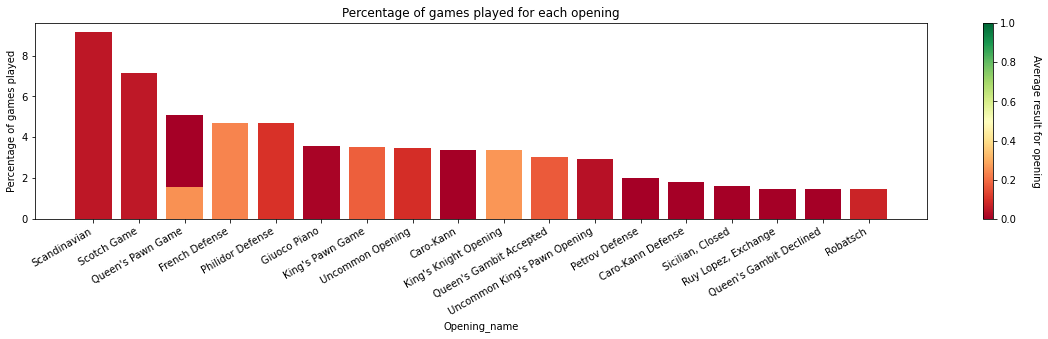

Text(0.5, 0, 'Opening_name')

Text(0, 0.5, 'Average Result')

Text(0.5, 1.0, 'Average result of your best 20 openings')

<Figure size 432x288 with 0 Axes>

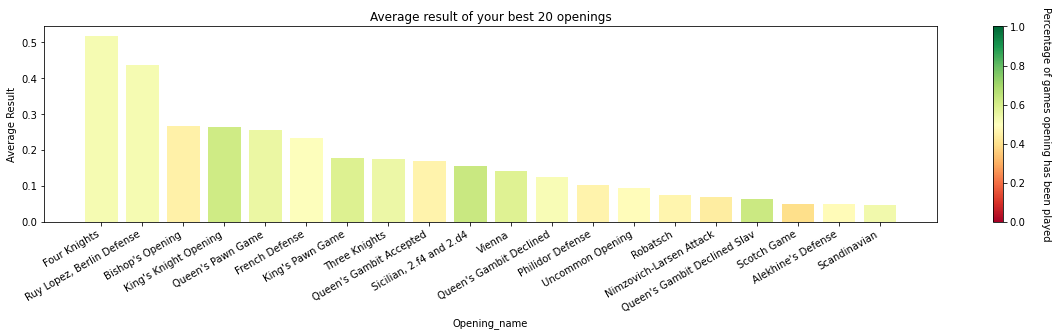

Text(0.5, 0, 'Opening_name')

Text(0, 0.5, 'Average Result')

Text(0.5, 1.0, 'Average result of your worst 20 openings')

<Figure size 432x288 with 0 Axes>

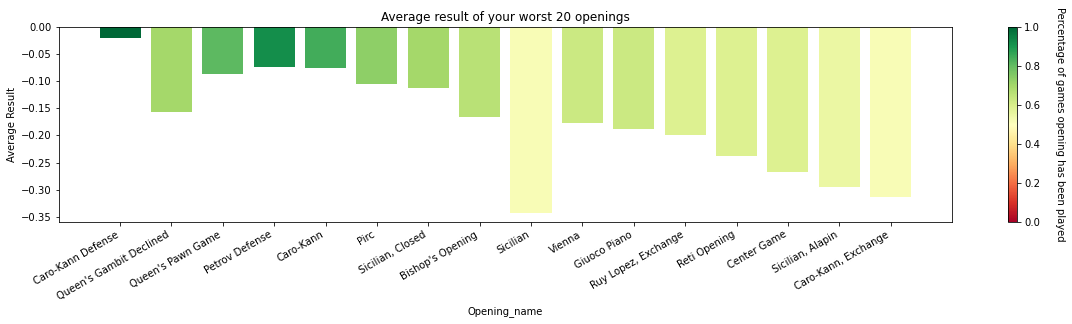

Text(0.5, 0, 'EC0')

Text(0, 0.5, 'Percentage of games played')

Text(0.5, 1.0, 'Percentage of games played for each opening')

<Figure size 432x288 with 0 Axes>

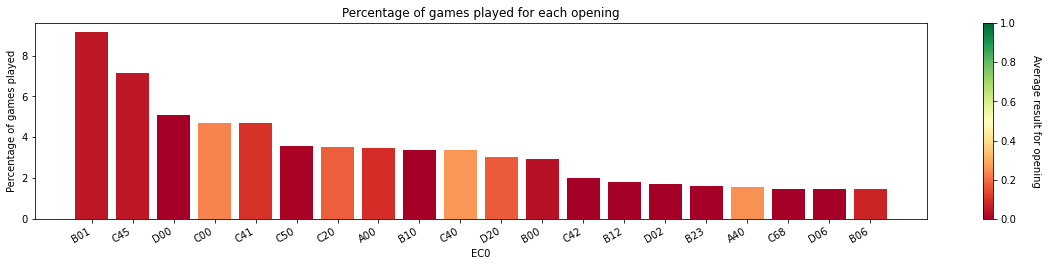

Text(0.5, 0, 'EC0')

Text(0, 0.5, 'Average Result')

Text(0.5, 1.0, 'Average result of your best 20 openings')

<Figure size 432x288 with 0 Axes>

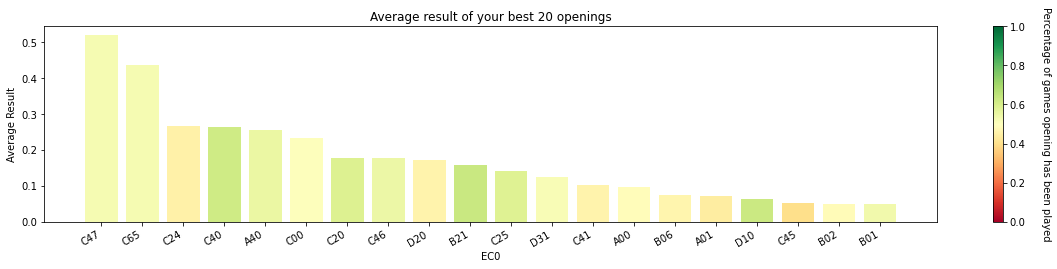

Text(0.5, 0, 'EC0')

Text(0, 0.5, 'Average Result')

Text(0.5, 1.0, 'Average result of your worst 20 openings')

<Figure size 432x288 with 0 Axes>

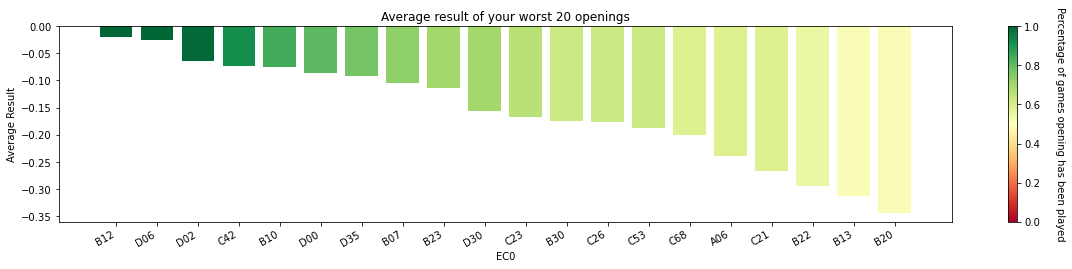

In [379]:
#Bar chart of each ECO opening vs how much i've played. Need to take first 10 results and order by percentage_of_games
#If I want to colour bars to represent 3rd variable (average result for each opening) would be useful.

list = ['Opening_name', 'EC0']

for x in list:

    mask = (EC0_vs_result.percentage_of_games > 0.5)
    data_color = EC0_vs_result[mask].sort_values(by='percentage_of_games', ascending=False).head(20).result_numerical
    normmin = -1
    normmax = 1
    # data_color = [(x-normmin) / (normmax-normmin) for x in data_color]
    data_x = EC0_vs_result[mask].sort_values(by='percentage_of_games', ascending=False).head(20)[x]
    data_y = EC0_vs_result[mask].sort_values(by='percentage_of_games', ascending=False).head(20).percentage_of_games
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    fig, ax = plt.subplots(figsize=(20, 4))
    my_cmap = plt.cm.get_cmap('RdYlGn')
    colors = my_cmap(data_color)
    rects = ax.bar(data_x, data_y, color=colors)
    sm = ScalarMappable(cmap=my_cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Average result for opening', rotation=270,labelpad=25)
    plt.xlabel(x)
    plt.ylabel('Percentage of games played')
    plt.title('Percentage of games played for each opening')
    plt.gcf().autofmt_xdate()
    plt.show()

    #Bar chart of each ECO opening vs avg result (for openings I've played more than 0.5% of games)
    #If i want colour of bars to represent 3rd variable (percentage of games played for that opening
    # try here: https://stackoverflow.com/questions/65094280/python-barplot-colored-according-to-a-third-variable)
    #20 best:

    data_x_2 = EC0_vs_result[mask].sort_values(by='result_numerical', ascending=False).head(20)[x]
    data_y_2 = EC0_vs_result[mask].sort_values(by='result_numerical', ascending=False).head(20).result_numerical
    data_color_2 = EC0_vs_result[mask].sort_values(by='percentage_of_games', ascending=False).head(20).percentage_of_games
    normmin = -1
    normmax = 1
    data_color_2 = [(x-normmin) / (normmax-normmin) for x in data_color]
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    fig, ax = plt.subplots(figsize=(20, 4))
    my_cmap = plt.cm.get_cmap('RdYlGn')
    colors = my_cmap(data_color_2)
    rects = ax.bar(data_x_2, data_y_2, color=colors)
    sm = ScalarMappable(cmap=my_cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Percentage of games opening has been played', rotation=270,labelpad=25)
    plt.xlabel(x)
    plt.ylabel('Average Result')
    plt.title('Average result of your best 20 openings')
    plt.gcf().autofmt_xdate()
    plt.show()

    #20 worst openings
    data_x_3 = EC0_vs_result[mask].sort_values(by='result_numerical', ascending=False).tail(20)[x]
    data_y_3 = EC0_vs_result[mask].sort_values(by='result_numerical', ascending=False).tail(20).result_numerical
    data_color_3 = EC0_vs_result[mask].sort_values(by='percentage_of_games', ascending=False).tail(20).percentage_of_games
    normmin = -1
    normmax = 1
    data_color_2 = [(x-normmin) / (normmax-normmin) for x in data_color]
    plt.tight_layout()
    fig, ax = plt.subplots(figsize=(20, 4))
    my_cmap = plt.cm.get_cmap('RdYlGn')
    colors = my_cmap(data_color_3)
    rects = ax.bar(data_x_3, data_y_3, color=colors)
    sm = ScalarMappable(cmap=my_cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Percentage of games opening has been played', rotation=270,labelpad=25)
    plt.xlabel(x)
    plt.ylabel('Average Result')
    plt.title('Average result of your worst 20 openings')
    plt.gcf().autofmt_xdate()
    plt.show()

<Figure size 432x288 with 0 Axes>

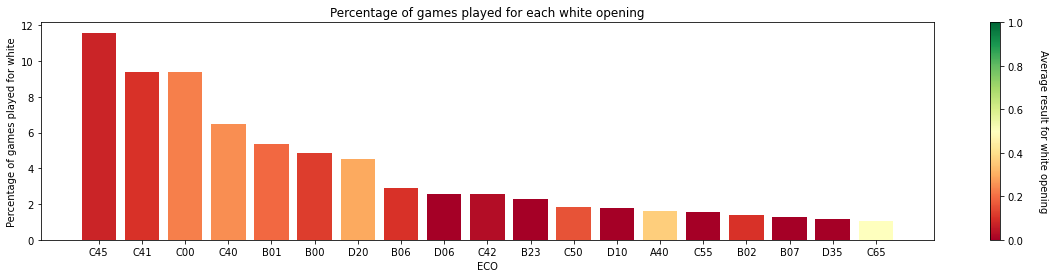

<Figure size 432x288 with 0 Axes>

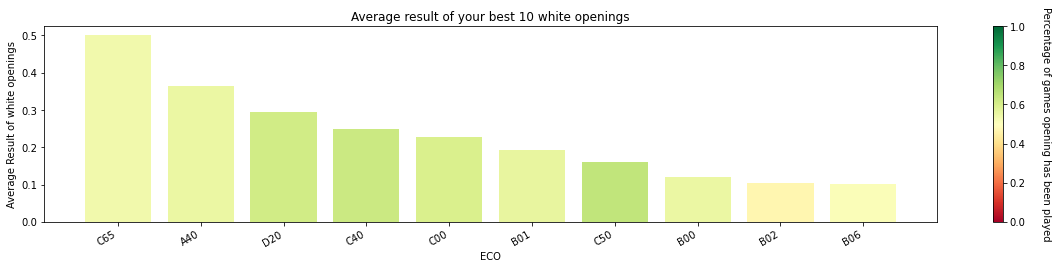

<Figure size 432x288 with 0 Axes>

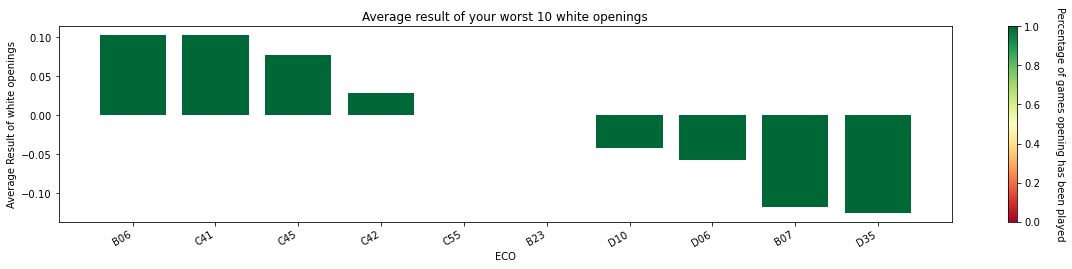

In [677]:
#Same as above but for white
EC0_vs_result_white = pd.DataFrame(chess_data[white_mask].groupby(by='EC0').mean().result_numerical)
EC0_vs_result_white['percentage_of_games'] = (chess_data['EC0'][white_mask].value_counts()  * 100 / chess_data[white_mask].shape[0])
EC0_vs_result_white['EC0'] = EC0_vs_result_white.index
mask = EC0_vs_result_white['percentage_of_games'] > 1
data_color = EC0_vs_result_white[mask].sort_values(by='percentage_of_games', ascending=False).head(20).result_numerical
normmin = -1
normmax = 1
# data_color = [(x-normmin) / (normmax-normmin) for x in data_color]
data_x = EC0_vs_result_white[mask].sort_values(by='percentage_of_games', ascending=False).head(20).EC0
data_y = EC0_vs_result_white[mask].sort_values(by='percentage_of_games', ascending=False).head(20).percentage_of_games
plt.tight_layout()
plt.gcf().autofmt_xdate()
fig, ax = plt.subplots(figsize=(20, 4))
my_cmap = plt.cm.get_cmap('RdYlGn')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_y, color=colors)
sm = ScalarMappable(cmap=my_cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Average result for white opening', rotation=270,labelpad=25)
plt.xlabel('ECO')
plt.ylabel('Percentage of games played for white')
plt.title('Percentage of games played for each white opening')
plt.show()

#Bar chart of each ECO opening vs avg result (for openings I've played more than 0.5% of games)
#If i want colour of bars to represent 3rd variable (percentage of games played for that opening
# try here: https://stackoverflow.com/questions/65094280/python-barplot-colored-according-to-a-third-variable)
#20 best:

data_x_2 = EC0_vs_result_white[mask].sort_values(by='result_numerical', ascending=False).head(10).EC0
data_y_2 = EC0_vs_result_white[mask].sort_values(by='result_numerical', ascending=False).head(10).result_numerical
data_color_2 = EC0_vs_result_white[mask].sort_values(by='percentage_of_games', ascending=False).head(10).percentage_of_games
normmin = -1
normmax = 1
data_color_2 = [(x-normmin) / (normmax-normmin) for x in data_color]
plt.tight_layout()
plt.gcf().autofmt_xdate()
fig, ax = plt.subplots(figsize=(20, 4))
my_cmap = plt.cm.get_cmap('RdYlGn')
colors = my_cmap(data_color_2)
rects = ax.bar(data_x_2, data_y_2, color=colors)
sm = ScalarMappable(cmap=my_cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Percentage of games opening has been played', rotation=270,labelpad=25)
plt.xlabel('ECO')
plt.ylabel('Average Result of white openings')
plt.title('Average result of your best 10 white openings')
plt.gcf().autofmt_xdate()
plt.show()

# #20 worst openings
data_x_3 = EC0_vs_result_white[mask].sort_values(by='result_numerical', ascending=False).tail(10).EC0
data_y_3 = EC0_vs_result_white[mask].sort_values(by='result_numerical', ascending=False).tail(10).result_numerical
data_color_3 = EC0_vs_result_white[mask].sort_values(by='percentage_of_games', ascending=False).tail(10).percentage_of_games
normmin = -1
normmax = 1
data_color_2 = [(x-normmin) / (normmax-normmin) for x in data_color]
plt.tight_layout()
fig, ax = plt.subplots(figsize=(20, 4))
my_cmap = plt.cm.get_cmap('RdYlGn')
colors = my_cmap(data_color_3)
rects = ax.bar(data_x_3, data_y_3, color=colors)
sm = ScalarMappable(cmap=my_cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Percentage of games opening has been played', rotation=270,labelpad=25)
plt.xlabel('ECO')
plt.ylabel('Average Result of white openings')
plt.title('Average result of your worst 10 white openings')
plt.gcf().autofmt_xdate()
plt.show()

In [676]:
EC0_vs_result_white[mask].sort_values(by='result_numerical')

,result_numerical,percentage_of_games,EC0
EC0,,,
D35,-0.125000,1.180812,D35
B07,-0.117647,1.254613,B07
D06,-0.057143,2.583026,D06
D10,-0.041667,1.771218,D10
C55,0.000000,1.549815,C55
B23,0.000000,2.287823,B23
C42,0.028571,2.583026,C42
C45,0.076433,11.586716,C45
C41,0.102362,9.372694,C41


<Figure size 432x288 with 0 Axes>

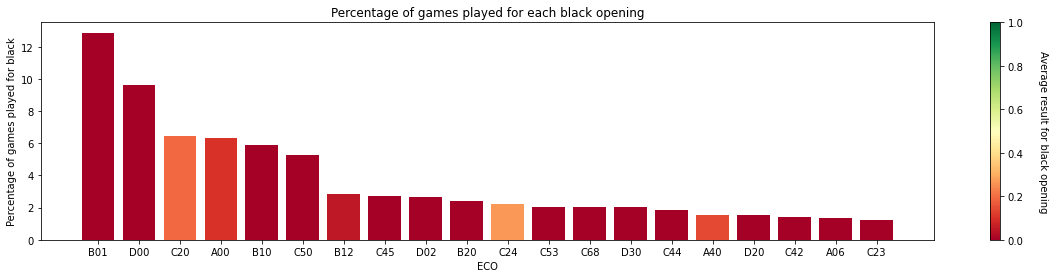

<Figure size 432x288 with 0 Axes>

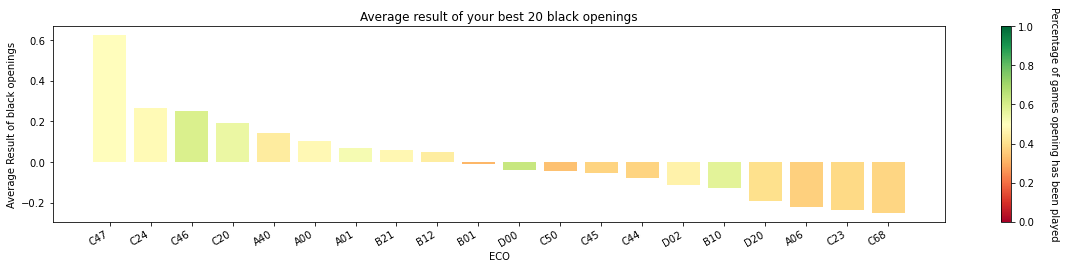

<Figure size 432x288 with 0 Axes>

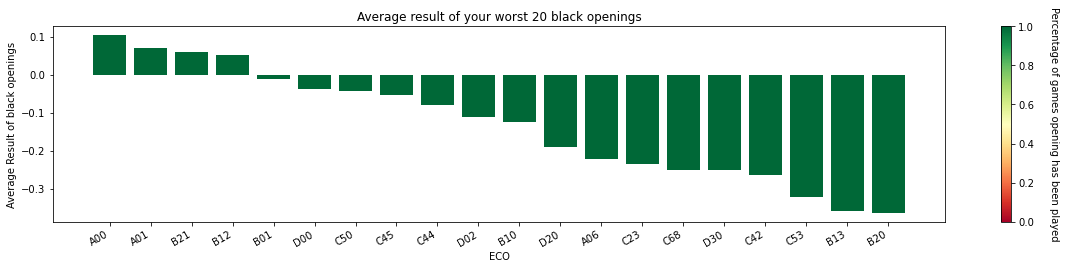

In [670]:
#Same as above but for black

EC0_vs_result_black = pd.DataFrame(chess_data[black_mask].groupby(by='EC0').mean().result_numerical)
EC0_vs_result_black['percentage_of_games'] = (chess_data['EC0'][black_mask].value_counts()  * 100 / chess_data[black_mask].shape[0])
EC0_vs_result_black['EC0'] = EC0_vs_result_black.index
mask = EC0_vs_result_black['percentage_of_games'] > 1
data_color = EC0_vs_result_black[mask].sort_values(by='percentage_of_games', ascending=False).head(20).result_numerical
normmin = -1
normmax = 1
# data_color = [(x-normmin) / (normmax-normmin) for x in data_color]
data_x = EC0_vs_result_black[mask].sort_values(by='percentage_of_games', ascending=False).head(20).EC0
data_y = EC0_vs_result_black[mask].sort_values(by='percentage_of_games', ascending=False).head(20).percentage_of_games
plt.tight_layout()
plt.gcf().autofmt_xdate()
fig, ax = plt.subplots(figsize=(20, 4))
my_cmap = plt.cm.get_cmap('RdYlGn')
colors = my_cmap(data_color)
rects = ax.bar(data_x, data_y, color=colors)
sm = ScalarMappable(cmap=my_cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Average result for black opening', rotation=270,labelpad=25)
plt.xlabel('ECO')
plt.ylabel('Percentage of games played for black')
plt.title('Percentage of games played for each black opening')
plt.show()

#Bar chart of each ECO opening vs avg result (for openings I've played more than 0.5% of games)
#If i want colour of bars to represent 3rd variable (percentage of games played for that opening
# try here: https://stackoverflow.com/questions/65094280/python-barplot-colored-according-to-a-third-variable)
#20 best:

data_x_2 = EC0_vs_result_black[mask].sort_values(by='result_numerical', ascending=False).head(20).EC0
data_y_2 = EC0_vs_result_black[mask].sort_values(by='result_numerical', ascending=False).head(20).result_numerical
data_color_2 = EC0_vs_result_black[mask].sort_values(by='percentage_of_games', ascending=False).head(20).percentage_of_games
normmin = -1
normmax = 1
data_color_2 = [(x-normmin) / (normmax-normmin) for x in data_color]
plt.tight_layout()
plt.gcf().autofmt_xdate()
fig, ax = plt.subplots(figsize=(20, 4))
my_cmap = plt.cm.get_cmap('RdYlGn')
colors = my_cmap(data_color_2)
rects = ax.bar(data_x_2, data_y_2, color=colors)
sm = ScalarMappable(cmap=my_cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Percentage of games opening has been played', rotation=270,labelpad=25)
plt.xlabel('ECO')
plt.ylabel('Average Result of black openings')
plt.title('Average result of your best 20 black openings')
plt.gcf().autofmt_xdate()
plt.show()

# #20 worst openings
data_x_3 = EC0_vs_result_black[mask].sort_values(by='result_numerical', ascending=False).tail(20).EC0
data_y_3 = EC0_vs_result_black[mask].sort_values(by='result_numerical', ascending=False).tail(20).result_numerical
data_color_3 = EC0_vs_result_black[mask].sort_values(by='percentage_of_games', ascending=False).tail(20).percentage_of_games
normmin = -1
normmax = 1
data_color_2 = [(x-normmin) / (normmax-normmin) for x in data_color]
plt.tight_layout()
fig, ax = plt.subplots(figsize=(20, 4))
my_cmap = plt.cm.get_cmap('RdYlGn')
colors = my_cmap(data_color_3)
rects = ax.bar(data_x_3, data_y_3, color=colors)
sm = ScalarMappable(cmap=my_cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Percentage of games opening has been played', rotation=270,labelpad=25)
plt.xlabel('ECO')
plt.ylabel('Average Result of black openings')
plt.title('Average result of your worst 20 black openings')
plt.gcf().autofmt_xdate()
plt.show()

In [664]:
EC0_vs_result_black[EC0_vs_result_black['percentage_of_games'] > 1].sort_values(by='percentage_of_games')

,result_numerical,percentage_of_games,EC0
EC0,,,
A01,0.071429,1.029412,A01
B13,-0.357143,1.029412,B13
C47,0.625000,1.176471,C47
C46,0.250000,1.176471,C46
B21,0.058824,1.250000,B21
C23,-0.235294,1.250000,C23
A06,-0.222222,1.323529,A06
C42,-0.263158,1.397059,C42
A40,0.142857,1.544118,A40


In [60]:
#Looking at highs and lows of various thingsfor each opening

for i in df_num:
    print('*******LOOKING AT', i, 'for different openings' + '********')
    pd.DataFrame(chess_data.groupby(by='EC0').mean()[i])

    df = pd.DataFrame(chess_data.groupby(by='EC0').mean()[i])
    df['percentage_of_games'] = (chess_data['EC0'].value_counts()  * 100 / chess_data.shape[0])
    mask = (df.percentage_of_games > 1) # only look at openings which have been played more than 1% of games
    print(df[mask].sort_values(by='percentage_of_games', ascending=False).iloc[0:1, 0:2], 'Most played opening')
    print(df[mask].sort_values(by='percentage_of_games', ascending=True).iloc[0:1, 0:2], 'Least played opening')
    print(df[mask].sort_values(by=i, ascending=False).iloc[0:1, 0:2], 'largest', i)
    print(df[mask].sort_values(by=i, ascending=True).iloc[0:1, 0:2], 'smallest', i)
    print('\n\n')

*******LOOKING AT black_elo for different openings********
       black_elo  percentage_of_games
EC0                                  
B01  1013.173387             9.134438 Most played opening
       black_elo  percentage_of_games
EC0                                  
C44  1157.103448              1.06814 Least played opening
       black_elo  percentage_of_games
EC0                                  
D10  1435.419355             1.141805 largest black_elo
      black_elo  percentage_of_games
EC0                                 
B20  896.171429             1.289134 smallest black_elo



*******LOOKING AT white_elo for different openings********
       white_elo  percentage_of_games
EC0                                  
B01  1020.258065             9.134438 Most played opening
       white_elo  percentage_of_games
EC0                                  
C44  1147.103448              1.06814 Least played opening
       white_elo  percentage_of_games
EC0                                  
D10

In [61]:
#Avg ELO difference for each opening

pd.DataFrame(chess_data.groupby(by='EC0').mean().elo_difference)

EC0_vs_elo_difference = pd.DataFrame(chess_data.groupby(by='EC0').mean().elo_difference)
EC0_vs_elo_difference['percentage_of_games'] = (chess_data['EC0'].value_counts()  * 100 / chess_data.shape[0])
mask = (EC0_vs_elo_difference.percentage_of_games > 1) # only look at openings which have been played more than 1% of games
print(EC0_vs_elo_difference[mask].elo_difference.max(), 'Best Avg result of opening')
print(EC0_vs_elo_difference[mask].elo_difference.min(), 'Worst Avg result of opening')
print(EC0_vs_elo_difference[mask].sort_values(by='percentage_of_games', ascending=False).iloc[0:1, 0:2], 'Most played opening')
print(EC0_vs_elo_difference[mask].sort_values(by='percentage_of_games', ascending=True).iloc[0:1, 0:2], 'Least played opening')
print(EC0_vs_elo_difference[mask].sort_values(by='elo_difference', ascending=False).iloc[0:1, 0:2], 'Most positive difference')
print(EC0_vs_elo_difference[mask].sort_values(by='elo_difference', ascending=True).iloc[0:1, 0:2], 'Most negative difference')

4.485714285714286 Best Avg result of opening
-26.53191489361702 Worst Avg result of opening
     elo_difference  percentage_of_games
EC0                                     
B01        0.673387             9.134438 Most played opening
     elo_difference  percentage_of_games
EC0                                     
C44      -21.448276              1.06814 Least played opening
     elo_difference  percentage_of_games
EC0                                     
B20        4.485714             1.289134 Most positive difference
     elo_difference  percentage_of_games
EC0                                     
A00      -26.531915             3.462247 Most negative difference


In [62]:
#Avg ELO for each opening

pd.DataFrame(chess_data.groupby(by='EC0').mean().elo_difference)

EC0_vs_elo_difference = pd.DataFrame(chess_data.groupby(by='EC0').mean().elo_difference)
EC0_vs_elo_difference['percentage_of_games'] = (chess_data['EC0'].value_counts()  * 100 / chess_data.shape[0])
mask = (EC0_vs_elo_difference.percentage_of_games > 1) # only look at openings which have been played more than 1% of games
print(EC0_vs_elo_difference[mask].elo_difference.max(), 'Best Avg result of opening')
print(EC0_vs_elo_difference[mask].elo_difference.min(), 'Worst Avg result of opening')
print(EC0_vs_elo_difference[mask].sort_values(by='percentage_of_games', ascending=False).iloc[0:1, 0:2], 'Most played opening')
print(EC0_vs_elo_difference[mask].sort_values(by='percentage_of_games', ascending=True).iloc[0:1, 0:2], 'Least played opening')
print(EC0_vs_elo_difference[mask].sort_values(by='elo_difference', ascending=False).iloc[0:1, 0:2], 'Most positive difference')
print(EC0_vs_elo_difference[mask].sort_values(by='elo_difference', ascending=True).iloc[0:1, 0:2], 'Most negative difference')

4.485714285714286 Best Avg result of opening
-26.53191489361702 Worst Avg result of opening
     elo_difference  percentage_of_games
EC0                                     
B01        0.673387             9.134438 Most played opening
     elo_difference  percentage_of_games
EC0                                     
C44      -21.448276              1.06814 Least played opening
     elo_difference  percentage_of_games
EC0                                     
B20        4.485714             1.289134 Most positive difference
     elo_difference  percentage_of_games
EC0                                     
A00      -26.531915             3.462247 Most negative difference


In [ ]:
#Avg colour for each opening

In [63]:
#Shortest and longest openings

EC0_vs_game_length = pd.DataFrame(chess_data.groupby(by='EC0').mean().game_length_m)
EC0_vs_game_length['percentage_of_games'] = (chess_data['EC0'].value_counts()  * 100 / chess_data.shape[0])
mask = (EC0_vs_game_length.percentage_of_games > 1) # only look at openings which have been played more than 1% of games
print(EC0_vs_game_length[mask].game_length_m.max(), 'Avg length of most played opening')
print(EC0_vs_game_length[mask].game_length_m.min(), 'Avg length of least played opening')
print(EC0_vs_game_length[mask].percentage_of_games.max(), 'Most played opening percentage')
print(EC0_vs_game_length[mask].percentage_of_games.min(), 'Least played opening percentage')
print(EC0_vs_game_length[mask].sort_values(by='percentage_of_games', ascending=False).iloc[0:1, 0:2], 'Most played opening')
print(EC0_vs_game_length[mask].sort_values(by='percentage_of_games', ascending=True).iloc[0:1, 0:2], 'Least played opening')
print(EC0_vs_game_length[mask].sort_values(by='game_length_m', ascending=False).iloc[0:1, 0:2], 'Longest opening')
print(EC0_vs_game_length[mask].sort_values(by='game_length_m', ascending=True).iloc[0:1, 0:2], 'Shortest opening')

# EC0_vs_game_length[mask].sort_values(by='game_length_m')


12.163870967741937 Avg length of most played opening
8.916551724137932 Avg length of least played opening
9.134438305709024 Most played opening percentage
1.0681399631675874 Least played opening percentage
     game_length_m  percentage_of_games
EC0                                    
B01       9.521129             9.134438 Most played opening
     game_length_m  percentage_of_games
EC0                                    
C44       8.916552              1.06814 Least played opening
     game_length_m  percentage_of_games
EC0                                    
D10      12.163871             1.141805 Longest opening
     game_length_m  percentage_of_games
EC0                                    
C44       8.916552              1.06814 Shortest opening


In [64]:
chess_data.groupby(by='Previous_result').mean()

#we see here we're slightly more likely to win next game if we win, and still if we lose but less so.
#Draws actually predict a loss for the next game

,white_elo,black_elo,game_length_s,game_length_m,game_id,my_elo,opponent_elo,elo_difference,colour_numerical,result_numerical,...,Day_in_month,Hour,Minute,Second,daily_game_count,daily_result_aggregate,length_of_last_game,time_since_last_game_m,trigger_factor,my_elo_av
Previous_result,,,,,,,,,,,,,,,,,,,,,
-1,1143.213934,1141.556557,613.292623,10.221516,1353.946721,1143.561475,1141.209016,-2.352459,0.491803,0.020492,...,15.615574,14.687705,29.645082,29.408197,4.178689,0.363934,10.049934,420.911631,-0.090734,1142.267163
0,1190.834320,1193.171598,613.378698,10.223018,1431.863905,1193.852071,1190.153846,-3.698225,0.556213,-0.130178,...,15.165680,14.414201,28.402367,29.218935,3.958580,1.183432,14.288402,347.584438,0.000000,1192.315079
1,1150.883107,1146.196078,631.198341,10.519992,1352.315234,1151.361991,1145.717195,-5.644796,0.498492,0.078431,...,16.235294,14.595023,29.484917,28.822021,4.705128,1.930618,10.153145,305.448906,0.101668,1150.032365


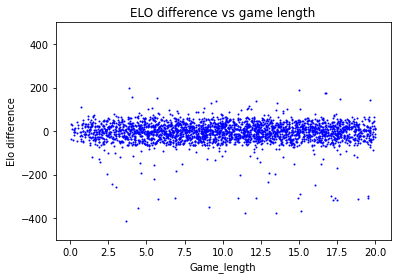

In [65]:
#plot game length vs elo difference
#No correlation

plt.plot(chess_data['game_length_m'], chess_data['elo_difference'], '.', markersize=2, color = 'blue')

plt.xlabel('Game_length')
plt.ylabel('Elo difference')
plt.ylim([-500, 500])
plt.title('ELO difference vs game length')
plt.show;

In [ ]:
#plot elo difference vs likelihood to win

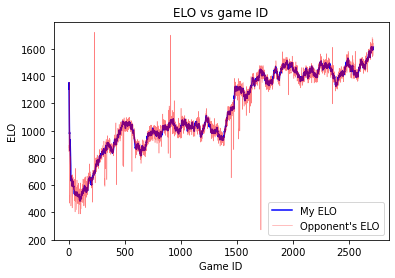

In [123]:
#my_elo/opponent elo vs game_id

plt.plot(chess_data['game_id'], chess_data['my_elo'], label='My ELO', color = 'blue')
plt.plot(chess_data['game_id'], chess_data['opponent_elo'],linewidth=0.5,alpha=0.5,label='Opponent\'s ELO',color = 'red')

plt.xlabel('Game ID')
plt.ylabel('ELO')

plt.title('ELO vs game ID')
plt.legend(loc='lower right')
plt.show;

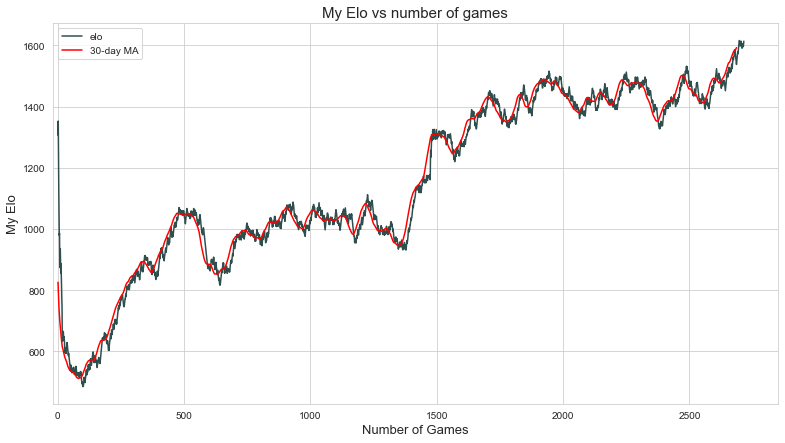

In [74]:
sns.set_style("whitegrid")
plt.figure(figsize=(13, 7))

sns.lineplot(y='my_elo', 
             x=chess_data.game_id,
             data=chess_data, 
             color='darkslategray')

sns.lineplot(y='my_elo_av', 
             x=chess_data.game_id,
             data=chess_data, 
             color='red')

plt.xlabel('Number of Games', fontsize=13)
plt.ylabel('My Elo', fontsize=13)
plt.title('My Elo vs number of games', fontsize=15)
plt.xlim(-20)

plt.legend(['elo', '30-day MA'])


plt.show()

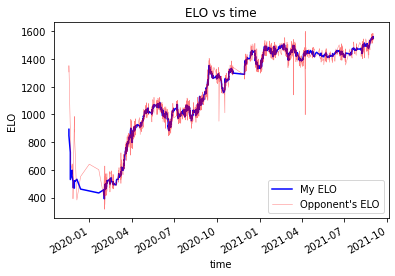

In [53]:
#my elo/opponent elo vs time

plt.plot(chess_data['time'], chess_data['my_elo'], label='My ELO', color = 'blue')
plt.plot(chess_data['time'], chess_data['opponent_elo'],linewidth=0.5,alpha=0.5,label='Opponent\'s ELO',color = 'red')

plt.xlabel('time')
plt.ylabel('ELO')
plt.gcf().autofmt_xdate()

plt.title('ELO vs time')
plt.legend(loc='lower right')

plt.show;

In [ ]:
#average number of moves for win vs loss vs draw



<function matplotlib.pyplot.show(close=None, block=None)>

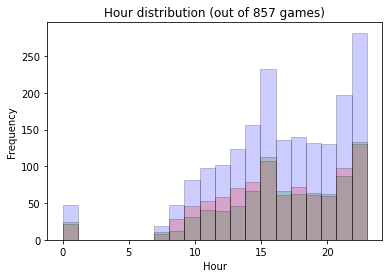

In [54]:
#plot number of games vs hour in the day

graph = plt.hist(chess_data['Hour'], color = 'blue', edgecolor = 'black', bins = 20, alpha=0.2)
plt.title(f'Hour distribution (out of {sample_size} games)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show

#plot number of wins vs hour in the day

graph2 = plt.hist(chess_data_win['Hour'], color = 'red', edgecolor = 'black', bins = 20, alpha=0.2)
plt.title(f'Hour distribution (out of {sample_size_win} games)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show

#plot number of losses vs hour in the day

graph3 = plt.hist(chess_data_loss['Hour'], color = 'green', edgecolor = 'black', bins = 20, alpha=0.2)
plt.title(f'Hour distribution (out of {sample_size_loss} games)')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show

In [ ]:
#Win rate vs hour of day

ConversionError: Failed to convert value(s) to axis units: array([datetime.time(22, 4, 41), datetime.time(22, 12),
       datetime.time(3, 20, 20), ..., datetime.time(9, 51, 43),
       datetime.time(9, 37, 22), datetime.time(9, 46, 50)], dtype=object)

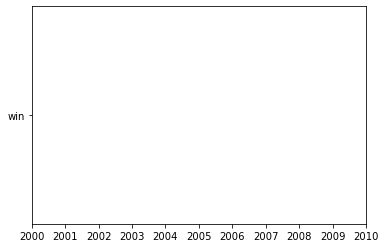

In [1176]:
# #Games over time

# graph = plt.plot_date(chess_data['Time'], chess_data['result'], color = 'blue')
# plt.title(f'Hour distribution (out of {sample_size} games)')
# plt.xlabel('Hour')
# plt.ylabel('Frequency')
# plt.show;

In [ ]:
#plot win rate over time
#win rate = % of games which were my win




In [ ]:
#plot win rate over time for white

In [ ]:
#plot win rate over time for black

In [ ]:
#plot win rate for each hour of day (histogram?)


In [ ]:
#plot win rate for black vs white

Text(0, 0.5, 'White elo')

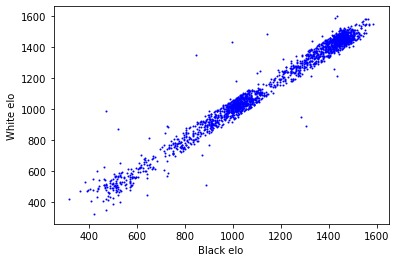

In [55]:
#plot black elo vs white elo

graph = plt.plot(chess_data['black_elo'], chess_data['white_elo'], '.', markersize=2, color = 'blue')

plt.xlabel('Black elo')
plt.ylabel('White elo')

In [ ]:
#plot win rate for each day of the week (bar chart?)

Text(0, 0.5, 'Opponent elo')

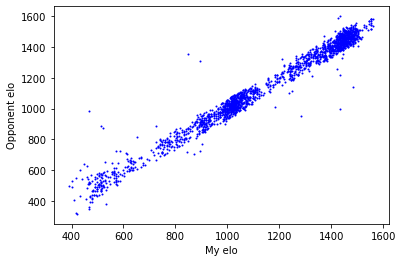

In [56]:
#plot my elo vs opponent elo

graph = plt.plot(chess_data['my_elo'], chess_data['opponent_elo'], '.', markersize=2, color = 'blue')

plt.xlabel('My elo')
plt.ylabel('Opponent elo')

In [ ]:
-----------------

#MACHINE LEARNING

-----------------

In [57]:
X = chess_data[['black_elo']]
y = chess_data.white_elo

In [58]:
lr = LinearRegression()
lr.fit(X,y)

LinearRegression()

In [59]:
ic.ic(lr.intercept_)
ic.ic(lr.coef_)

ic| lr.intercept_: 21.46151984915332
ic| lr.coef_: array([0.98262264])


array([0.98262264])

In [839]:
# new_values = [[800], [1600], [1700], [200], [2000]]
# lr.predict(new_values)

array([ 949.19583194, 1566.02949917, 1643.13370758,  486.57058151,
       1874.44633279])

In [60]:
lr.score(X,y) # returns R^2. Best possible score is 1.0

0.9744237143133626

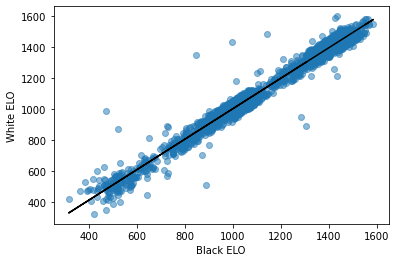

In [61]:
plt.scatter(X, y, linewidths=1, alpha=0.5)
plt.xlabel('Black ELO')
plt.ylabel('White ELO')
plt.plot(X, lr.predict(X), color='k')

In [ ]:
# The steps to building and using a model are:

# Define: What type of model will it be? A decision tree? Some other type of model? 
# Some other parameters of the model type are specified too. I think this will be logistic regression or decision tree

# Fit: Capture patterns from provided data. This is the heart of modeling.

# Predict: Just what it sounds like

# Evaluate: Determine how accurate the model's predictions are.

In [62]:
y_ = chess_data.result_numerical
features = ['elo_difference', 'game_length_m', 'colour_numerical', 'Hour', 'Day', 'Day_in_month', 'game_id', 'daily_game_count', 'daily_result_aggregate', 'time_since_last_game_m', 'Previous_result', 'trigger_factor','time_since_last_game_m']
#Would like to add 'last_game_result', and 'cumulative_result_that_day'
X_ = chess_data[features]


In [63]:
train_X, val_X, train_y, val_y = train_test_split(X_, y_)

In [64]:
chess_model = DecisionTreeRegressor()
chess_model.fit(train_X,train_y)

DecisionTreeRegressor()

In [397]:
# made_up_data = pd.DataFrame({'elo_difference': [1000, -1000,-100, 0, 0, 100, 2000, -2000], 'game_length_m': [10,10,10,10,10,10,10,10], 'colour_numerical': [1,1,1,0,1,1,1,1]})
# made_up_data

,elo_difference,game_length_m,colour_numerical
0,1000,10,1
1,-1000,10,1
2,-100,10,1
3,0,10,0
4,0,10,1
5,100,10,1
6,2000,10,1
7,-2000,10,1


In [590]:
# input_predictions = chess_model.predict(made_up_data)
# input_predictions

ValueError: X has 4 features, but DecisionTreeRegressor is expecting 6 features as input.

In [399]:
# made_up_data['predicted_result'] = input_predictions
# made_up_data
# Where result = 1 (win), 0 (draw), -1 (loss)
# Positive elo_difference indicates opponent has higher elo

,elo_difference,game_length_m,colour_numerical,predicted_result
0,1000,10,1,-1.0
1,-1000,10,1,1.0
2,-100,10,1,1.0
3,0,10,0,1.0
4,0,10,1,-1.0
5,100,10,1,-1.0
6,2000,10,1,-1.0
7,-2000,10,1,1.0


In [65]:
val_predictions = chess_model.predict(val_X)

In [66]:
validation_table = pd.DataFrame(val_y)
validation_table['result_predictions'] = val_predictions
validation_table.result_predictions = validation_table.result_predictions.apply(int)
validation_table.reset_index()
validation_table['Prediction_correct'] = validation_table.result_numerical == validation_table.result_predictions
print(validation_table.Prediction_correct.value_counts())
print(validation_table['result_numerical'].value_counts())
print(validation_table['result_predictions'].value_counts())

validation_table

#Predicted 317 correct and 165 incorrect, not bad. 

True     317
False    165
Name: Prediction_correct, dtype: int64
-1    239
 1    215
 0     28
Name: result_numerical, dtype: int64
 1    230
-1    225
 0     27
Name: result_predictions, dtype: int64


,result_numerical,result_predictions,Prediction_correct
1884,-1,1,False
1243,1,-1,False
885,-1,0,False
75,-1,-1,True
817,-1,0,False
...,...,...,...
1141,1,1,True
1844,1,1,True
5,-1,-1,True
188,-1,-1,True


In [67]:

vtwl = validation_table[validation_table['result_numerical'] == 1].count()[1] # validation table win length
mask_w = ((validation_table['result_numerical'] == 1) & (validation_table['Prediction_correct'] == True))
cwc = validation_table[mask_w].sum()[0] #correct win count

print('rate of correct win prediction:', cwc/vtwl)

vtll = validation_table[validation_table['result_numerical'] == -1].count()[1] # validation table win length
mask_l = ((validation_table['result_numerical'] == -1) & (validation_table['Prediction_correct'] == True))
clc = validation_table[mask_l].sum()[1] #correct win count

print('rate of correct loss prediction:', -clc/vtll)

vtdl = validation_table[validation_table['result_numerical'] == 0].count()[1] # validation table draw length
mask_d = ((validation_table['result_numerical'] == 0) & (validation_table['Prediction_correct'] == True))
cdc = validation_table[mask_d].sum()[2] #correct draw count

print('rate of correct draw prediction:', cdc/vtdl)




rate of correct win prediction: 0.7348837209302326
rate of correct loss prediction: 0.6610878661087866
rate of correct draw prediction: 0.03571428571428571


In [68]:
mean_absolute_error(val_y, val_predictions)
#adding in daily_game_count and daily_result_aggregate decreases error from 0.77 to 0.67


0.5746887966804979

In [69]:
importance = chess_model.feature_importances_
importance
#importance of each feature

array([0.41255534, 0.08578997, 0.02003424, 0.06633622, 0.04048238,
       0.05761217, 0.08481848, 0.04021538, 0.02683053, 0.04906877,
       0.00131397, 0.05937103, 0.05557151])

,white_elo,black_elo,game_length_s,game_length_m,game_id,my_elo,opponent_elo,elo_difference,colour_numerical,result_numerical,...,Day_in_month,Hour,Minute,Second,daily_game_count,daily_result_aggregate,Previous_result,length_of_last_game,time_since_last_game_m,trigger_factor
white_elo,1.000000,0.987129,0.083041,0.083034,0.936906,0.993259,0.993834,-0.021071,-0.008071,-0.042717,...,0.081764,-0.038099,0.026765,0.010011,-0.133453,0.042387,-0.008532,0.078852,-0.011671,0.041210
black_elo,0.987129,1.000000,0.085983,0.085980,0.937474,0.993887,0.993263,-0.028544,-0.009413,-0.045706,...,0.081681,-0.039822,0.020904,0.009576,-0.129737,0.043090,-0.007737,0.077771,-0.013904,0.039147
game_length_s,0.083041,0.085983,1.000000,1.000000,0.081207,0.079528,0.089521,0.060128,-0.015180,-0.123997,...,-0.004943,0.010613,0.032302,-0.027015,-0.032929,0.018721,0.019941,0.019388,-0.006178,0.021519
game_length_m,0.083034,0.085980,1.000000,1.000000,0.081209,0.079525,0.089516,0.060117,-0.015194,-0.123991,...,-0.004938,0.010635,0.032300,-0.027017,-0.032927,0.018730,0.019957,0.019398,-0.006183,0.021525
game_id,0.936906,0.937474,0.081207,0.081209,1.000000,0.943620,0.930727,-0.103543,-0.007252,-0.017866,...,0.059478,-0.035522,0.025514,0.009787,-0.139987,0.027963,-0.016848,0.081397,0.013827,0.028518
my_elo,0.993259,0.993887,0.079528,0.079525,0.943620,1.000000,0.987113,-0.104902,-0.006065,-0.007362,...,0.077819,-0.041156,0.023891,0.007690,-0.131256,0.044292,-0.005899,0.080195,-0.019251,0.039040
opponent_elo,0.993834,0.993263,0.089521,0.089516,0.930727,0.987113,1.000000,0.055589,-0.011434,-0.081214,...,0.085641,-0.036760,0.023764,0.011903,-0.131927,0.041180,-0.010378,0.076417,-0.006303,0.041316
elo_difference,-0.021071,-0.028544,0.060128,0.060117,-0.103543,-0.104902,0.055589,1.000000,-0.033217,-0.458781,...,0.046684,0.028343,-0.001380,0.025992,-0.000911,-0.020442,-0.027690,-0.025471,0.080946,0.013173
colour_numerical,-0.008071,-0.009413,-0.015180,-0.015194,-0.007252,-0.006065,-0.011434,-0.033217,1.000000,0.022350,...,0.007062,-0.020410,-0.014380,0.029080,-0.007423,-0.000264,0.002516,-0.036325,-0.007657,0.005800
result_numerical,-0.042717,-0.045706,-0.123997,-0.123991,-0.017866,-0.007362,-0.081214,-0.458781,0.022350,1.000000,...,-0.031752,-0.044052,-0.025764,-0.025972,-0.004043,0.033274,0.014372,0.003443,-0.031531,-0.010862


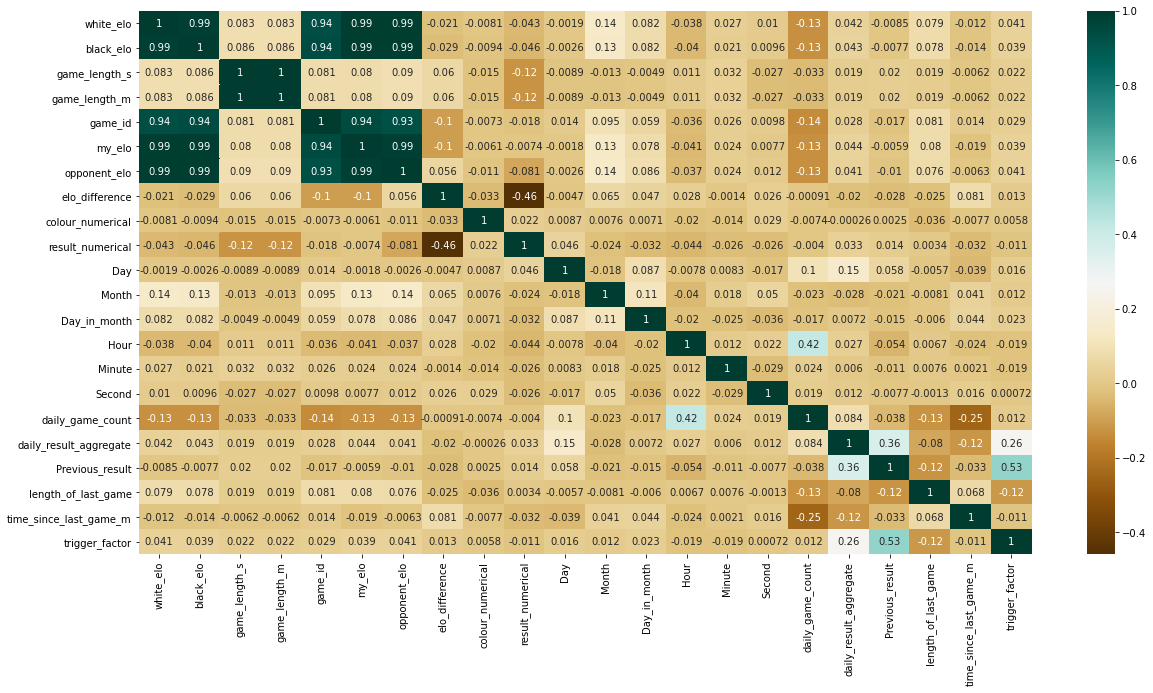

In [70]:
#correlation heatmap
plt.figure(figsize=(20,10))
c= chess_data.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

In [71]:
chess_data.to_csv(f'chess_data_{person_of_interest}.csv')